In [1]:
#!/usr/bin/python2.7

# Contents of the paper on eye movement analysis

## Configuration

In [2]:
from pyene_analysis.config import DATA_PATH
from pyene_analysis.config import MODEL_PATH
from pyene_analysis.config import PNG_PATH
from ema import EyeMovementDataFrame
from ema import html_report
from ema import Model
import numpy as np
from openalea.sequence_analysis import Estimate
from openalea.sequence_analysis import Plot
import os
import pandas as pd
import random
import matplotlib.pyplot as plt

random.seed(9812496)

##### Check pandas version

In [3]:
print pd.__version__

0.23.4


In [4]:
import xlrd
xlrd.__version__

'1.2.0'

##### Enabling R extensions

In [5]:
%load_ext rpy2.ipython

#####  Place variables in markdown outputs

In [6]:
from IPython.display import Markdown
from IPython.core.magic import register_cell_magic


@register_cell_magic
def markdown(line, cell):
    return Markdown(cell.format(**globals()))

## Determining if images have to be saved

In [7]:
# Create image directory if 
import os
image_path = "images"

save_images = True

if save_images and (not os.path.exists(image_path)):
    os.mkdir(image_path)

## Loading and preparing data

Remark: the data file name 'y35' refers to vertical tolerance to assign fixations to words

In [8]:
df = pd.read_excel(os.path.join(DATA_PATH,'em-y35-fasttext.xlsx'))

In [9]:
df.head()

SUBJ SUBJ_NAME  TEXT_NO               TEXT  ANSWER  FIX_NUM  FIX_LATENCY  \
0     1       s01        1  chasse_oiseaux-a1       1        1          202   
1     1       s01        1  chasse_oiseaux-a1       1        2          321   
2     1       s01        1  chasse_oiseaux-a1       1        3          477   
3     1       s01        1  chasse_oiseaux-a1       1        4          792   
4     1       s01        1  chasse_oiseaux-a1       1        5         1085   

       X      Y  FDUR     ...      COS_INST_FASTTEXT_2016  \
0  296.8  267.9    96     ...                    0.184662   
1  345.3  266.9   129     ...                    0.184662   
2  430.8  266.5   280     ...                    0.207028   
3  557.4  278.1   278     ...                    0.171182   
4  571.6  276.7   266     ...                    0.171182   

   COS_CUM_FASTTEXT_2016  WFREQ_RANK_FASTTEXT_2016  COS_INST_FASTTEXT_2018  \
0               0.184662                    8205.0                0.186901   
1               0.184662                    8205.0                0.186901   
2               0.222649                   12071.0                0.221362   
3               0.240086                    1217.0                0.256207   
4               0.241489                    1217.0                0.256207   

   COS_CUM_FASTTEXT_2018  WFREQ_RANK_FASTTEXT_2018  WFREQ_RANK_FASTTEXT_1618  \
0               0.186901                    5590.0                    6897.5   
1               0.186901                    5590.0                    6897.5   
2               0.228615                   18406.0                   15238.5   
3               0.254959                    2094.0                    1655.5   
4               0.268313                    2094.0                    1655.5   

   COS_INST_FASTTEXT_1618  COS_CUM_FASTTEXT_1618 TEXT_TYPE_2  
0                0.185782               0.185782           a  
1                0.185782               0.185782           a  
2                0.214195               0.225632           a  
3                0.213694               0.247522           a  
4                0.213694               0.254901           a  

[5 rows x 37 columns]

__Variable names__

In [10]:
str(list([str(i) for i in df.columns]))

"['SUBJ', 'SUBJ_NAME', 'TEXT_NO', 'TEXT', 'ANSWER', 'FIX_NUM', 'FIX_LATENCY', 'X', 'Y', 'FDUR', 'OFF_DUR', 'SACAMP', 'SACOR', 'INEEG', 'ISFIRST', 'ISLAST', 'READMODE', 'WINC', 'CINC', 'FIXED_WORD', 'FIXED_WINDOW', 'WORD_FREQUENCY', 'COS_INST', 'COS_CUM', 'SACDIR', 'NEW_READ_WORDS', 'TEXT_TYPE', 'COS_INST_FASTTEXT_2016', 'COS_CUM_FASTTEXT_2016', 'WFREQ_RANK_FASTTEXT_2016', 'COS_INST_FASTTEXT_2018', 'COS_CUM_FASTTEXT_2018', 'WFREQ_RANK_FASTTEXT_2018', 'WFREQ_RANK_FASTTEXT_1618', 'COS_INST_FASTTEXT_1618', 'COS_CUM_FASTTEXT_1618', 'TEXT_TYPE_2']"

__Check that TEXT_TYPE_2 corresponds to {'a','f','f+','m'}__ 

In [11]:
assert(set(df.TEXT_TYPE_2)=={'a','f','f+','m'})

__Rename with English initials {'UR','HR','HR+','MR'}__ 

In [12]:
fr_tt = ['a','f','f+','m'] # French text types
en_tt = ['UR', 'HR', 'HR+', 'MR'] # English text types
for s in range(len(fr_tt)):
    df.TEXT_TYPE_2[df.TEXT_TYPE_2==fr_tt[s]] = en_tt[s]
    df.TEXT_TYPE[df.TEXT_TYPE==fr_tt[s]] = en_tt[s]
assert(set(df.TEXT_TYPE_2)==set(en_tt))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [13]:
df.READMODE.unique()

array([ 0,  1,  2, -2, -1])

In [14]:
def redefine_readmode(dataframe, type=0):
    df = dataframe.copy()
    if type == 0:
        df.at[df.WINC > 1, 'READMODE'] = 4
        df.at[df.WINC == 1, 'READMODE'] = 3
        df.at[df.WINC == 0, 'READMODE'] = 2
        df.at[df.WINC == -1, 'READMODE'] = 1
        df.at[df.WINC < -1, 'READMODE'] = 0
    if type == 1:
        df['READMODE'] = 5
        df.at[df.WINC == 2, 'READMODE'] = 4
        df.at[df.WINC == 1, 'READMODE'] = 3
        df.at[df.WINC == 0, 'READMODE'] = 2
        df.at[df.WINC == -1, 'READMODE'] = 1
        df.at[df.WINC < -1, 'READMODE'] = 0
    elif type == 2:
        df['READMODE'] = 6
        df.at[df.WINC == 2, 'READMODE'] = 5
        df.at[df.WINC == 1, 'READMODE'] = 4
        df.at[df.WINC == 0, 'READMODE'] = 3
        df.at[df.WINC == -1, 'READMODE'] = 2
        df.at[df.WINC == -2, 'READMODE'] = 1
        df.at[df.WINC < -2, 'READMODE'] = 0
    elif type == 3:
        df['READMODE'] = 2
        df.at[df.WINC > 2, 'READMODE'] = 4
        df.at[df.WINC == 2, 'READMODE'] = 3
        df.at[df.WINC == -1, 'READMODE'] = 1
        df.at[df.WINC < -1, 'READMODE'] = 0
    df['READMODE'] = pd.Categorical(df.READMODE)
    return df

In [15]:
df = redefine_readmode(df, type=0)
df = EyeMovementDataFrame(df)

## Exploratory analysis (no model here)

### Effect of text type on saccade amplitude

Compute saccade amplitude in degrees.   
Distance to screen: 68 cm   
Resolution: 1024./52. pixels / cm

In [16]:
dist_to_screen = 68
Resolution = 1024/52

In [17]:
df['SACAMPD'] =  (360/np.pi)* np.arctan(df['SACAMP']/(2*dist_to_screen*Resolution))

In [18]:
df[['TEXT_TYPE', 'SACAMPD']].groupby('TEXT_TYPE').mean()

SACAMPD
TEXT_TYPE          
HR         5.968008
MR         6.069322
UR         5.845540

In [19]:
df[['TEXT_TYPE', 'SACAMPD']].groupby('TEXT_TYPE').std()

SACAMPD
TEXT_TYPE          
HR         4.425812
MR         4.488097
UR         4.311820

In [20]:
import seaborn as sns
sns.set(color_codes=True);

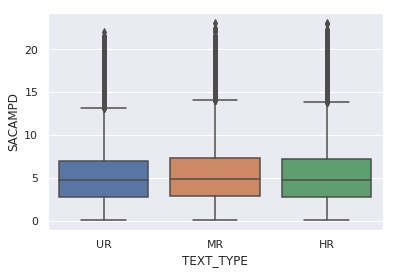

In [21]:
ax = sns.boxplot(x="TEXT_TYPE", y="SACAMPD", data=df)

if save_images:
    plt.savefig(image_path + os.sep + "sacampd_per_text_type.svg", format="svg")

Print R version

In [22]:
%%R 
R.Version()$version.string

[1] "R version 3.4.4 (2018-03-15)"


In [23]:
%%R 

set.seed(0)

In [24]:
import tempfile
tempdir = tempfile.mkdtemp()

In [25]:
SACAMPD_file = os.path.join(tempdir, 'sampd_file.csv')
df[['TEXT_TYPE', 'SUBJ', 'SACAMPD']].to_csv(SACAMPD_file)

In [26]:
%%R -i SACAMPD_file
if(!require(lme4)){
    install.packages("lme4")
    library(lme4)
}

df_SACAMPD = read.table(SACAMPD_file, sep=",", row.names=1, header=TRUE)
names(df_SACAMPD) = c("TEXT_TYPE", "SUBJ", "SACAMPD")
df_SACAMPD$SUBJ = factor(df_SACAMPD$SUBJ)

mod_sacampd = lmer(SACAMPD ~ TEXT_TYPE + (1|SUBJ), data=df_SACAMPD)
mod_sacampd_mle = lmer(SACAMPD ~ TEXT_TYPE + (1|SUBJ), data=df_SACAMPD, REML=FALSE) # MLE
mod_sacampd_null_mle = lmer(SACAMPD ~ (1|SUBJ), data=df_SACAMPD, REML=FALSE) # NULL model

print(summary(mod_sacampd))
print("------------")
print(anova(mod_sacampd_mle, mod_sacampd_null_mle, test="Chisq"))

/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: lme4

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)


Linear mixed model fit by REML ['lmerMod']
Formula: SACAMPD ~ TEXT_TYPE + (1 | SUBJ)
   Data: df_SACAMPD

REML criterion at convergence: 228780.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6700 -0.6844 -0.2673  0.2600  4.0602 

Random effects:
 Groups   Name        Variance Std.Dev.
 SUBJ     (Intercept)  0.6365  0.7978  
 Residual             18.9692  4.3554  
Number of obs: 39564, groups:  SUBJ, 15

Fixed effects:
            Estimate Std. Error t value
(Intercept)  6.03043    0.20983  28.739
TEXT_TYPEMR  0.10393    0.05246   1.981
TEXT_TYPEUR -0.10328    0.05655  -1.826

Correlation of Fixed Effects:
            (Intr) TEXT_TYPEM
TEXT_TYPEMR -0.140           
TEXT_TYPEUR -0.130  0.520    
convergence code: 0
Model failed to converge with max|grad| = 0.00256183 (tol = 0.002, component 1)

[1] "------------"
Data: df_SACAMPD
Models:
mod_sacampd_null_mle: SACAMPD ~ (1 | SUBJ)
mod_sacampd_mle: SACAMPD ~ TEXT_TYPE + (1 | SUBJ)
                     Df    AIC    BIC  l

Significance of random effect: BIC

In [27]:
%%R 

BICLM = function(model) {
    # Compute BIC for mixed models, see Delattre et al. (2014)
    BICLM = 0.
    if (isREML(model)) {
        # REML estimated models must be refitted (use logML)
        modrML = refitML(model)
        BICLM = -2 * logLik(modrML)
    } else {
        BICLM = -2 * logLik(model)
    }
    # different types of random effects in formula
    # It is assumed that each random effect 
    # has a fixed counterpart (intercept)
    n_grps = ngrps(model) 
    neff = length(n_grps)
    for (e in 1:neff) {
        BICLM = BICLM + log(n_grps[e]) * 2 
    }

    fix_ef = length(fixef(model))
    if ("(Intercept)" %in% names(fixef(model))) {
        # Counted in random effects
        fix_ef = fix_ef - 1
    }
    BICLM = BICLM + fix_ef * log(nobs(model))
    return(as.double(BICLM))
}


In [28]:
%%R -o mod_sacampd_BICLM -o mod_sacampd_BICLM_f

cat("BIC value (mixed model):")
mod_sacampd_BICLM = BICLM(mod_sacampd)
print(mod_sacampd_BICLM)
cat("BIC value (linear model):")
mod_sacampd_BICLM_f = BIC(lm(SACAMPD ~ TEXT_TYPE, data=df_SACAMPD))
print(mod_sacampd_BICLM_f)
print(paste("BIC difference:", mod_sacampd_BICLM-mod_sacampd_BICLM_f))

BIC value (mixed model):[1] 228797.6
BIC value (linear model):[1] 229877.5
[1] "BIC difference: -1079.87138213366"


In [29]:
%%R 

# Sample size
summary(df_SACAMPD$TEXT_TYPE)

   HR    MR    UR 
12316 15745 11503 


Significance of random effect: confidence interval

In [30]:
%%R 

confint(mod_sacampd, method="profile", level=0.995, oldNames = FALSE)

/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Computing profile confidence intervals ...

  warnings.warn(x, RRuntimeWarning)


                         0.25 %    99.75 %
sd_(Intercept)|SUBJ  0.49252542 1.43537591
sigma                4.31214786 4.39909092
(Intercept)          5.38084709 6.68083575
TEXT_TYPEMR         -0.04333861 0.25120085
TEXT_TYPEUR         -0.26203574 0.05544514


In [31]:
%%R 

confint(mod_sacampd, method="profile", level=0.92, oldNames = FALSE)

                            4 %         96 %
sd_(Intercept)|SUBJ  0.57418032  1.105836419
sigma                4.32828717  4.382509504
(Intercept)          5.65718795  6.403957233
TEXT_TYPEMR          0.01208498  0.195777258
TEXT_TYPEUR         -0.20229523 -0.004295319


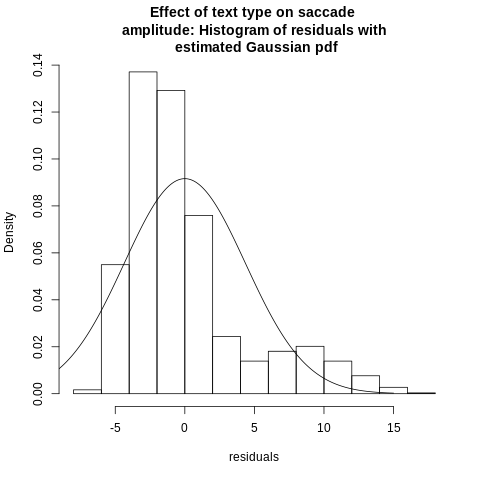

In [32]:
%%R -i save_images -i image_path


if (save_images) {
    svg(paste(image_path,"/sacampd_lmm_residuals.svg", sep=""))
    hist(residuals(mod_sacampd), main="Effect of text type on saccade \n amplitude: Histogram of residuals with \n estimated Gaussian pdf", prob=TRUE, xlab="residuals")
    lines(seq(-15,15,length.out=500), dnorm(seq(-15,15,length.out=500), mean=mean(residuals(mod_sacampd)),sd=sd(residuals(mod_sacampd))))
    dev.off()
}

hist(residuals(mod_sacampd), main="Effect of text type on saccade \n amplitude: Histogram of residuals with \n estimated Gaussian pdf", prob=TRUE, xlab="residuals")
lines(seq(-15,15,length.out=500), dnorm(seq(-15,15,length.out=500), mean=mean(residuals(mod_sacampd)),sd=sd(residuals(mod_sacampd))))


In [33]:
%%R 

# Subsample to have sample size 5000 (limitation of shapiro.test) 
subsample = sample(residuals(mod_sacampd), 5000)
print(shapiro.test(subsample))
print(paste("Sample size:", length(subsample)))
print(summary(subsample))


	Shapiro-Wilk normality test

data:  subsample
W = 0.85235, p-value < 2.2e-16

[1] "Sample size: 5000"
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-6.81837 -2.91628 -1.14148  0.08539  1.13260 16.34852 


### Effect of text type on fixation duration

In [34]:
df[['TEXT_TYPE', 'FDUR']].groupby('TEXT_TYPE').mean()

FDUR
TEXT_TYPE            
HR         185.815849
MR         184.165957
UR         181.870556

In [35]:
df[['TEXT_TYPE', 'FDUR']].groupby('TEXT_TYPE').std()

FDUR
TEXT_TYPE           
HR         66.984396
MR         66.672341
UR         65.541171

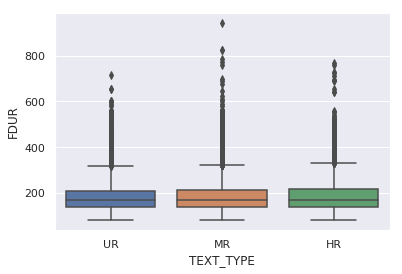

In [36]:
ax = sns.boxplot(x="TEXT_TYPE", y="FDUR", data=df)

if save_images:
    plt.savefig(image_path + os.sep + "fdur_per_text_type.svg", format="svg")

In [37]:
FDUR_file = os.path.join(tempdir, 'fdur_file.csv')
df[['TEXT_TYPE', 'SUBJ', 'FDUR']].to_csv(FDUR_file)

In [38]:
%%R -i FDUR_file
if(!require(lme4)){
    install.packages("lme4")
    library(lme4)
}

df_FDUR = read.table(FDUR_file, sep=",", row.names=1, header=TRUE)
names(df_FDUR) = c("TEXT_TYPE", "SUBJ", "FDUR")
df_FDUR$SUBJ = factor(df_FDUR$SUBJ)

mod_fdur = lmer(FDUR ~ TEXT_TYPE + (1|SUBJ), data=df_FDUR)
mod_fdur_mle = lmer(FDUR ~ TEXT_TYPE + (1|SUBJ), data=df_FDUR, REML=FALSE) # MLE
mod_fdur_null_mle = lmer(FDUR ~ (1|SUBJ), data=df_FDUR, REML=FALSE) # NULL model

print(summary(mod_fdur))
print("------------")
print(anova(mod_fdur_mle, mod_fdur_null_mle, test="Chisq"))

Linear mixed model fit by REML ['lmerMod']
Formula: FDUR ~ TEXT_TYPE + (1 | SUBJ)
   Data: df_FDUR

REML criterion at convergence: 439327.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6236 -0.6350 -0.1434  0.4716 12.4959 

Random effects:
 Groups   Name        Variance Std.Dev.
 SUBJ     (Intercept)  621.8   24.94   
 Residual             3882.9   62.31   
Number of obs: 39564, groups:  SUBJ, 15

Fixed effects:
            Estimate Std. Error t value
(Intercept) 186.3556     6.4636  28.832
TEXT_TYPEMR  -0.8448     0.7506  -1.126
TEXT_TYPEUR  -4.2443     0.8091  -5.246

Correlation of Fixed Effects:
            (Intr) TEXT_TYPEM
TEXT_TYPEMR -0.065           
TEXT_TYPEUR -0.060  0.520    
[1] "------------"
Data: df_FDUR
Models:
mod_fdur_null_mle: FDUR ~ (1 | SUBJ)
mod_fdur_mle: FDUR ~ TEXT_TYPE + (1 | SUBJ)
                  Df    AIC    BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)
mod_fdur_null_mle  3 439372 439398 -219683   439366                         
mod_fdur

Significance of random effect: BIC

In [39]:
%%R -o mod_fdur_BICLM -o mod_fdur_BICLM_f

cat("BIC value (mixed model):")
mod_fdur_BICLM = BICLM(mod_fdur)
print(mod_fdur_BICLM)
cat("BIC value (linear model):")
mod_fdur_BICLM_f = BIC(lm(FDUR ~ TEXT_TYPE, data=df_FDUR))
print(mod_fdur_BICLM_f)

BIC value (mixed model):[1] 439361.6
BIC value (linear model):[1] 444365.7


In [40]:
%%R 

# Sample size
summary(df_FDUR$TEXT_TYPE)

   HR    MR    UR 
12316 15745 11503 


Significance of random effect: confidence interval

In [41]:
%%R 

confint(mod_fdur, method="profile", level=0.995, oldNames = FALSE)

                        0.25 %    99.75 %
sd_(Intercept)|SUBJ  15.509447  44.695654
sigma                61.694628  62.938537
(Intercept)         166.273228 206.442916
TEXT_TYPEMR          -2.952055   1.262038
TEXT_TYPEUR          -6.515416  -1.973095


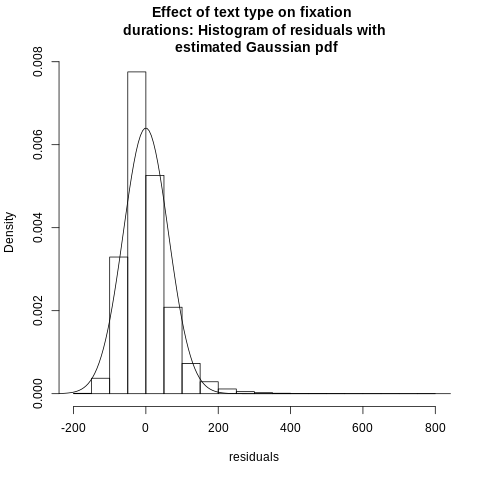

In [42]:
%%R -i save_images -i image_path


if (save_images) {
    svg(paste(image_path,"/fdur_lmm_residuals.svg", sep=""))
    hist(residuals(mod_fdur), main="Effect of text type on fixation \n durations: Histogram of residuals with \n estimated Gaussian pdf", prob=TRUE, xlab="residuals")
    lines(seq(-1500,1500,length.out=500), dnorm(seq(-1500,1500,length.out=500), mean=mean(residuals(mod_fdur)),sd=sd(residuals(mod_fdur))))
    dev.off()
}

hist(residuals(mod_fdur), main="Effect of text type on fixation \n durations: Histogram of residuals with \n estimated Gaussian pdf", prob=TRUE, xlab="residuals")
lines(seq(-1500,1500,length.out=500), dnorm(seq(-1500,1500,length.out=500), mean=mean(residuals(mod_fdur)),sd=sd(residuals(mod_fdur))))


In [43]:
%%R 

# Subsample to have sample size 5000 (limitation of shapiro.test) 
subsample = sample(residuals(mod_fdur), 5000)
print(shapiro.test(subsample))
print(paste("Sample size:", length(subsample)))
print(summary(subsample))


	Shapiro-Wilk normality test

data:  subsample
W = 0.92134, p-value < 2.2e-16

[1] "Sample size: 5000"
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-160.638  -40.648   -9.754   -2.406   25.918  593.276 


### Reading speed per text type

In [44]:
# Total number of new read words per text type
# UR, HR, MR
df[['TEXT_TYPE', 'NEW_READ_WORDS']].groupby('TEXT_TYPE').sum().reset_index()['NEW_READ_WORDS'] 

0    15751
1    19324
2    16922
Name: NEW_READ_WORDS, dtype: int64

In [45]:
# Check consistency of NEW_READ_WORDS
# Find a scanpath i with NEW_READ_WORDS > 0 for the 1st saccade
f = [i for i in range(df.shape[0]) if (df.iloc[i].ISFIRST == 1 and df.iloc[i].NEW_READ_WORDS > 0)]
if len(f) > 0:
    i = f[0]
else:
    print("Scanpath not found")
df.iloc[i]

SUBJ                                           1
SUBJ_NAME                                    s01
TEXT_NO                                        5
TEXT                        tourisme_montagne-a2
ANSWER                                         1
FIX_NUM                                        1
FIX_LATENCY                                  194
X                                          298.1
Y                                          275.5
FDUR                                         146
OFF_DUR                                        0
SACAMP                                   65.7019
SACOR                                   0.436033
INEEG                                          1
ISFIRST                                        1
ISLAST                                         0
READMODE                                       3
WINC                                           1
CINC                                           1
FIXED_WORD                                faut~1
FIXED_WINDOW        

In [46]:
# Find scanpath i for text "aide_refugies-a2" and subject 1
f = [i for i in range(df.shape[0]) if (df.iloc[i].SUBJ == 1 and df.iloc[i].TEXT == 'aide_refugies-a2')]
if len(f) > 0:
    si = f[0]
    print(df[['SUBJ', 'TEXT','TEXT_NO']].loc[si])
    print("With si = ", si)
    si = df[['TEXT_NO']].loc[si]
    si = si['TEXT_NO']
else:
    print("Scanpath not found")

SUBJ                      1
TEXT       aide_refugies-a2
TEXT_NO                  33
Name: 454, dtype: object
('With si = ', 454)


In [47]:
tutorial = False # Print intermediate results

In [48]:
# Scanpath durations
TNRW = df[['TEXT_TYPE','TEXT_NO','SUBJ','FIX_LATENCY','FDUR','ISLAST','NEW_READ_WORDS']]
SNRW = TNRW.FIX_LATENCY + TNRW.FDUR
SFS = pd.DataFrame(SNRW.rename('FIXSAC'))
TNRW = TNRW.join(SFS)
TNRWG = TNRW.groupby(['TEXT_TYPE','TEXT_NO','SUBJ'])['TEXT_TYPE','TEXT_NO','SUBJ','FIX_LATENCY','FIXSAC','ISLAST','NEW_READ_WORDS']
TFS = TNRWG.agg({'FIXSAC':'max'})['FIXSAC']
TFL = TNRWG.agg({'FIX_LATENCY':'min'})['FIX_LATENCY']
S2 = pd.DataFrame(pd.Series(TFS.FIXSAC.values-TFL.FIX_LATENCY.values).rename('SPDUR'))

# Scanpath durations
TFS['SPDUR'] = S2.values
# TFS[['TEXT_TYPE', 'SPDUR']].groupby('TEXT_TYPE').sum().reset_index()['SPDUR'] / 1000 / 60

df_WPM_SP = TNRWG.agg({'NEW_READ_WORDS':'sum'})['NEW_READ_WORDS'].NEW_READ_WORDS.values / (TFS['SPDUR'] / 60000)
# WPM: df_WPM_SP.values
if tutorial:
    print(TNRW.head(30))
    TNRWG.head(30)
    print(TNRWG.agg({'FIXSAC':'max'}).head(30))
    print(TNRWG.agg({'FIX_LATENCY':'min'}).head(30))
    print(TNRWG.agg({'NEW_READ_WORDS':'sum'}).head(30))
    TNRWG.agg({'FIXSAC':'max'}) - TNRWG.agg({'FIX_LATENCY':'min'})
    print(TNRWG.head(30))
    print(str(list([str(i) for i in TFS.columns])))
    print(TFS.head(30))

print(df_WPM_SP.head(30))


TEXT_TYPE  TEXT_NO  SUBJ
HR         1        1       303.518050
                    2       242.870285
                    3       153.987168
                    4       264.400378
                    5       195.516163
                    6       522.679483
                    7       359.884837
                    8       533.997864
                    9       247.654784
                    10      211.174659
                    11      183.787332
                    12      246.085011
                    13      433.070866
                    14      103.507763
                    15      399.652476
           2        1       325.011776
                    2       363.147276
                    3       334.872979
                    4       302.474794
                    5       267.707752
                    6       713.286713
                    7       218.181818
                    8       517.241379
                    9       233.354076
                    10      183.458187


In [49]:
df[['TEXT_TYPE', 'NEW_READ_WORDS', 'SUBJ', 'TEXT']].loc[pd.Series(df['SUBJ']==1) & pd.Series(df['TEXT']=='aide_refugies-a2')]

TEXT_TYPE  NEW_READ_WORDS  SUBJ              TEXT
454        UR               2     1  aide_refugies-a2
455        UR               2     1  aide_refugies-a2
456        UR               0     1  aide_refugies-a2
457        UR               3     1  aide_refugies-a2
458        UR               1     1  aide_refugies-a2
459        UR               3     1  aide_refugies-a2
460        UR               0     1  aide_refugies-a2
461        UR               4     1  aide_refugies-a2
462        UR               1     1  aide_refugies-a2
463        UR               1     1  aide_refugies-a2
464        UR               0     1  aide_refugies-a2
465        UR               2     1  aide_refugies-a2
466        UR               2     1  aide_refugies-a2
467        UR               2     1  aide_refugies-a2
468        UR               2     1  aide_refugies-a2
469        UR               0     1  aide_refugies-a2
470        UR               1     1  aide_refugies-a2
471        UR               3     1  aide_refugies-a2

In [50]:
TFST = TFS.T

In [51]:
# WPM: computation per text type
# Aggregation is at text type level: sum all 'NEW_READ_WORDS for that text type and divide by the sum of all SPDUR
df_WPM_TT = TFS.groupby(['TEXT_TYPE']).agg({'SPDUR':'sum'}) / 60000
df[['TEXT_TYPE', 'NEW_READ_WORDS']].groupby('TEXT_TYPE').sum().reset_index()['NEW_READ_WORDS'] / df_WPM_TT.reset_index()['SPDUR'] 

0    331.710803
1    318.633655
2    388.570965
dtype: float64

In [52]:
df_SPEED = df_WPM_SP.reset_index()
df_SPEED = df_SPEED.rename(columns={'SPDUR': 'READING_SPEED'})

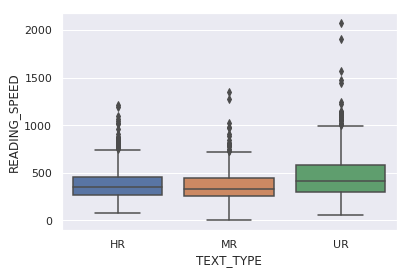

In [53]:
ax = sns.boxplot(x="TEXT_TYPE", y="READING_SPEED", data=df_SPEED)

if save_images:
    plt.savefig(image_path + os.sep + "speed_per_text_type.svg", format="svg")

Variant: compute speed at scanpath level and average

In [54]:
# WPM per scanpath and TEXT_TYPE
WPM_SP = df.groupby(['TEXT_TYPE', 'SUBJ', 'TEXT_NO'])['NEW_READ_WORDS'].agg('sum') / (TFS.groupby(['TEXT_TYPE', 'SUBJ', 'TEXT_NO'])['SPDUR'].agg('sum')  / 60000)

Below: same values as in article.   
Contrarily to df_WPM_TT, aggregation is threefold: TEXT_TYPE, SUBJ, TEXT_NO (the latter two fields defining a single scanpath)

In [55]:
WPM_SP.groupby(['TEXT_TYPE']).agg('mean')

TEXT_TYPE
HR    381.924775
MR    365.165009
UR    466.790974
dtype: float64

In [56]:
# To compute the dispersion of means per SUBJ wrt TEXT_TYPE means
# WPM_SP.groupby(['TEXT_TYPE','SUBJ']).agg('mean').groupby(['TEXT_TYPE']).agg('std', ddof=0) 

In [57]:
%%R 

set.seed(0)

In [58]:
WPM_file = os.path.join(tempdir, 'wpm_file.csv')
df_WPM_SP.to_csv(WPM_file)
# WPM_SP.to_csv(WPM_file)

Conclude to significance of text effect with a test

In [59]:
%%R -i WPM_file
if(!require(lme4)){
    install.packages("lme4")
    library(lme4)
}

df_WPM = read.table(WPM_file, sep=",")
names(df_WPM) = c("TEXT_TYPE", "TEXT_NO", "SUBJ", "WPM")
df_WPM$TEXT_NO = factor(df_WPM$TEXT_NO)
df_WPM$SUBJ = factor(df_WPM$SUBJ)

mod_wpm = lmer(WPM ~ TEXT_TYPE + (1|SUBJ), data=df_WPM)
mod_wpm_mle = lmer(WPM ~ TEXT_TYPE + (1|SUBJ), data=df_WPM, REML=FALSE) # MLE
mod_wpm_null_mle = lmer(WPM ~ (1|SUBJ), data=df_WPM, REML=FALSE) # NULL model

print(summary(mod_wpm))
print("------------")
print(anova(mod_wpm_mle, mod_wpm_null_mle, test="Chisq"))

Linear mixed model fit by REML ['lmerMod']
Formula: WPM ~ TEXT_TYPE + (1 | SUBJ)
   Data: df_WPM

REML criterion at convergence: 30771.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7245 -0.5587 -0.1009  0.3788  9.7978 

Random effects:
 Groups   Name        Variance Std.Dev.
 SUBJ     (Intercept) 15322    123.8   
 Residual             22417    149.7   
Number of obs: 2390, groups:  SUBJ, 15

Fixed effects:
            Estimate Std. Error t value
(Intercept)  377.478     32.400  11.650
TEXT_TYPEMR  -17.497      7.518  -2.327
TEXT_TYPEUR   85.067      7.482  11.369

Correlation of Fixed Effects:
            (Intr) TEXT_TYPEM
TEXT_TYPEMR -0.115           
TEXT_TYPEUR -0.116  0.496    
[1] "------------"
Data: df_WPM
Models:
mod_wpm_null_mle: WPM ~ (1 | SUBJ)
mod_wpm_mle: WPM ~ TEXT_TYPE + (1 | SUBJ)
                 Df   AIC   BIC logLik deviance  Chisq Chi Df Pr(>Chisq)    
mod_wpm_null_mle  3 31002 31020 -15498    30996                             
mod_wpm_mle      

Sample sizes

In [60]:
%%R 

table(df_WPM$TEXT_TYPE)


 HR  MR  UR 
803 785 802 


Significance of random effect: confidence interval 

In [61]:
%%R 

confint(mod_wpm, method="profile", level=0.995, oldNames = FALSE)

                       0.25 %   99.75 %
sd_(Intercept)|SUBJ  76.59339 222.37075
sigma               143.76561 155.96891
(Intercept)         277.00863 477.89334
TEXT_TYPEMR         -38.60892   3.61579
TEXT_TYPEUR          64.05488 106.07674


Significance of fixed effects: confidence interval

In [62]:
%%R 

confint(mod_wpm_mle, method="profile", level=0.995, oldNames = FALSE)

                       0.25 %   99.75 %
sd_(Intercept)|SUBJ  76.59339 222.37075
sigma               143.76561 155.96891
(Intercept)         277.00863 477.89334
TEXT_TYPEMR         -38.60892   3.61579
TEXT_TYPEUR          64.05488 106.07674


Significance of random effect: BIC

In [63]:
%%R 

BICLM = function(model) {
    # Compute BIC for mixed models, see Delattre et al. (2014)
    BICLM = 0.
    if (isREML(model)) {
        # REML estimated models must be refitted (use logML)
        modrML = refitML(model)
        BICLM = -2 * logLik(modrML)
    } else {
        BICLM = -2 * logLik(model)
    }
    # different types of random effects in formula
    # It is assumed that each random effect 
    # has a fixed counterpart (intercept)
    n_grps = ngrps(model) 
    neff = length(n_grps)
    for (e in 1:neff) {
        BICLM = BICLM + log(n_grps[e]) * 2 
    }

    fix_ef = length(fixef(mod_wpm))
    if ("(Intercept)" %in% names(fixef(model))) {
        # Counted in random effects
        fix_ef = fix_ef - 1
    }
    BICLM = BICLM + fix_ef * log(nobs(model))
    return(as.double(BICLM))
}


In [64]:
%%R -o mod_wpm_BICLM -o mod_wpm_BICLM_f

cat("BIC value (mixed model):")
mod_wpm_BICLM = BICLM(mod_wpm)
print(mod_wpm_BICLM)
cat("BIC value (linear model):")
mod_wpm_BICLM_f = BIC(lm(WPM ~ TEXT_TYPE, data=df_WPM))
print(mod_wpm_BICLM_f)

BIC value (mixed model):[1] 30812.77
BIC value (linear model):[1] 31928.87


For comparison: classical BIC

%%R

cat("BIC value (not fitted to mixed model):")
print(BIC(mod_wpm))

In [65]:
mod_wpm_BICLM

array([ 30812.76557781])

In [66]:
%%markdown


```The effect of text type on speed WPM is considered, computing WPM at scanpath scale.  
Test of individual effect (minimize BIC): strong individual effect  
BIC value (LMM mod_wpm): {mod_wpm_BICLM}   
BIC value (linear model):  {mod_wpm_BICLM_f}   
ANOVA in mixed model (effect of text type): 2.2e-16 (UR > (MR, HR))  
```



```The effect of text type on speed WPM is considered, computing WPM at scanpath scale.  
Test of individual effect (minimize BIC): strong individual effect  
BIC value (LMM mod_wpm): [ 30812.76557781]   
BIC value (linear model):  [ 31928.8673315]   
ANOVA in mixed model (effect of text type): 2.2e-16 (UR > (MR, HR))  
```

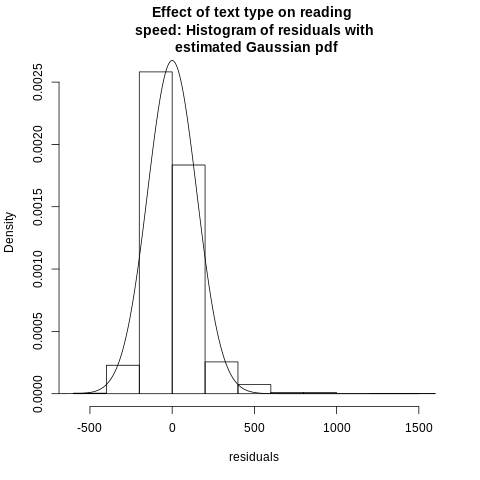

In [67]:
%%R -i save_images -i image_path


if (save_images) {
    svg(paste(image_path,"/wpm_lmm_residuals.svg", sep=""))
    hist(residuals(mod_wpm), main="Effect of text type on reading \n speed: Histogram of residuals with \n estimated Gaussian pdf", prob=TRUE, xlab="residuals")
    lines(seq(-1500,1500,length.out=500), dnorm(seq(-1500,1500,length.out=500), mean=mean(residuals(mod_wpm)),sd=sd(residuals(mod_wpm))))
    dev.off()
}

hist(residuals(mod_wpm), main="Effect of text type on reading \n speed: Histogram of residuals with \n estimated Gaussian pdf", prob=TRUE, xlab="residuals")
lines(seq(-1500,1500,length.out=500), dnorm(seq(-1500,1500,length.out=500), mean=mean(residuals(mod_wpm)),sd=sd(residuals(mod_wpm))))


In [68]:
%%R 

print(shapiro.test(residuals(mod_wpm)))
print(paste("Sample size:", length(residuals(mod_wpm))))
print(summary(residuals(mod_wpm)))


	Shapiro-Wilk normality test

data:  residuals(mod_wpm)
W = 0.89076, p-value < 2.2e-16

[1] "Sample size: 2390"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-407.93  -83.65  -15.11    0.00   56.71 1466.96 


Significant asymetry in empirical residuals

In [69]:
os.remove(WPM_file)

### Average number of fixations per text per text type

In [70]:
# avg nb fix per text
print(df[['TEXT_TYPE', 'ISFIRST']].groupby('TEXT_TYPE').count() / df[['TEXT_TYPE', 'ISFIRST']].groupby('TEXT_TYPE').sum())
print(df[['TEXT_TYPE', 'ISFIRST']].groupby('TEXT_TYPE').sum())

             ISFIRST
TEXT_TYPE           
HR         15.337484
MR         20.057325
UR         14.342893
           ISFIRST
TEXT_TYPE         
HR             803
MR             785
UR             802


In [71]:
# Number of fixations per scanpath
df_FST = df.groupby(['TEXT_TYPE','TEXT_NO','SUBJ'])['TEXT_TYPE','TEXT_NO','SUBJ','ISFIRST'].count()['ISFIRST']

In [72]:
# Total number of fixations per text type
df_COUNT = df[['TEXT_TYPE', 'ISFIRST']].groupby('TEXT_TYPE').sum()

In [73]:
df_NB_FIXATIONS = df_FST.to_frame(name="NB")
df_NB_FIXATIONS = df_NB_FIXATIONS.add_suffix('_FIXATIONS').reset_index()

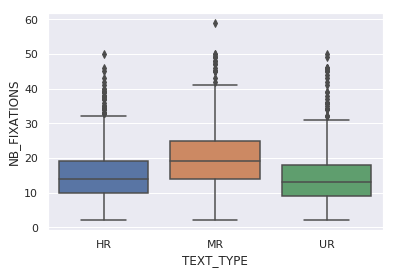

In [74]:
ax = sns.boxplot(x="TEXT_TYPE", y="NB_FIXATIONS", data=df_NB_FIXATIONS)

if save_images:
    plt.savefig(image_path + os.sep + "nb_fixations_per_text_type.svg", format="svg")

In [75]:
FST_file = os.path.join(tempdir, 'fst_file.csv')
df_FST.to_csv(FST_file)

Conclude to significance of text effect with a test

In [76]:
%%R -i FST_file

df_FST = read.table(FST_file, sep=",")
names(df_FST) = c("TEXT_TYPE", "TEXT_NO", "SUBJ", "NBFIX")
df_FST$TEXT_NO = factor(df_FST$TEXT_NO)
df_FST$SUBJ = factor(df_FST$SUBJ)

mod_fst = lmer(NBFIX ~ TEXT_TYPE + (1|SUBJ), data=df_FST)
mod_fst_mle = lmer(NBFIX ~ TEXT_TYPE + (1|SUBJ), data=df_FST, REML=FALSE) # MLE
mod_fst_null_mle = lmer(NBFIX ~ (1|SUBJ), data=df_FST, REML=FALSE) # NULL model

print(summary(mod_fst))
print("------------")
print(anova(mod_fst_mle, mod_fst_null_mle, test="Chisq"))


Linear mixed model fit by REML ['lmerMod']
Formula: NBFIX ~ TEXT_TYPE + (1 | SUBJ)
   Data: df_FST

REML criterion at convergence: 15912.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3730 -0.6462 -0.0723  0.5354  5.2196 

Random effects:
 Groups   Name        Variance Std.Dev.
 SUBJ     (Intercept) 24.84    4.984   
 Residual             44.43    6.665   
Number of obs: 2390, groups:  SUBJ, 15

Fixed effects:
            Estimate Std. Error t value
(Intercept)  15.2341     1.3086  11.642
TEXT_TYPEMR   4.7390     0.3347  14.159
TEXT_TYPEUR  -0.7840     0.3331  -2.354

Correlation of Fixed Effects:
            (Intr) TEXT_TYPEM
TEXT_TYPEMR -0.126           
TEXT_TYPEUR -0.128  0.496    
[1] "------------"
Data: df_FST
Models:
mod_fst_null_mle: NBFIX ~ (1 | SUBJ)
mod_fst_mle: NBFIX ~ TEXT_TYPE + (1 | SUBJ)
                 Df   AIC   BIC logLik deviance  Chisq Chi Df Pr(>Chisq)    
mod_fst_null_mle  3 16218 16235  -8106    16212                             
mod_fst_mle

Sample sizes

In [77]:
%%R 

table(df_FST$TEXT_TYPE)


 HR  MR  UR 
803 785 802 


In [78]:
%%R -o mod_fst_BICLM -o mod_fst_BICLM_f

cat("BIC value (mixed model):")
mod_fst_BICLM = BICLM(mod_fst)
print(mod_fst_BICLM)
cat("BIC value (linear model):")
mod_fst_BICLM_f = BIC(lm(NBFIX ~ TEXT_TYPE, data=df_FST))
print(mod_fst_BICLM_f)

BIC value (mixed model):[1] 15935.02
BIC value (linear model):[1] 16829.65


In [79]:
%%R 

confint(mod_fst, method="profile", level=0.995, oldNames = FALSE)

                       0.25 %   99.75 %
sd_(Intercept)|SUBJ  3.077267  8.963330
sigma                6.400059  6.943319
(Intercept)         11.178561 19.287541
TEXT_TYPEMR          3.799136  5.678865
TEXT_TYPEUR         -1.719633  0.151074


In [80]:
%%R 

confint(mod_fst_mle, method="profile", level=0.995, oldNames = FALSE)

                       0.25 %   99.75 %
sd_(Intercept)|SUBJ  3.077267  8.963330
sigma                6.400059  6.943319
(Intercept)         11.178561 19.287541
TEXT_TYPEMR          3.799136  5.678865
TEXT_TYPEUR         -1.719633  0.151074


In [81]:
%%markdown


```The effect of text type on numbers of fixations NBFIX is considered, computing NBFIX at scanpath scale.  
Test of individual effect (minimize BIC): strong individual effect  
BIC value (LMM mod_fst_mle): {mod_fst_BICLM}
BIC value (linear model): {mod_fst_BICLM_f}
ANOVA in mixed model (effect of text type): 2.2e-16 (UR < (MR, HR)) 
```



```The effect of text type on numbers of fixations NBFIX is considered, computing NBFIX at scanpath scale.  
Test of individual effect (minimize BIC): strong individual effect  
BIC value (LMM mod_fst_mle): [ 15935.01519968]
BIC value (linear model): [ 16829.65302289]
ANOVA in mixed model (effect of text type): 2.2e-16 (UR < (MR, HR)) 
```

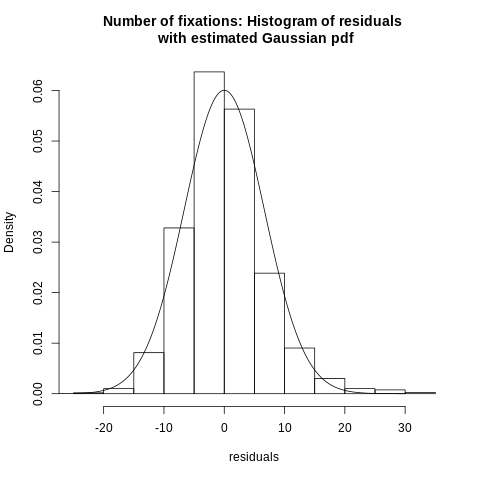

In [82]:
%%R -i save_images -i image_path

if (save_images) {
    svg(paste(image_path,"/fst_lmm_residuals.svg", sep=""))
    hist(residuals(mod_fst), main="Number of fixations: Histogram of residuals \n with estimated Gaussian pdf", prob=TRUE, xlab="residuals")
    lines(seq(-30,30,length.out=500), dnorm(seq(-30,30,length.out=500), mean=mean(residuals(mod_fst)),sd=sd(residuals(mod_fst))))
    dev.off()
}

hist(residuals(mod_fst), main="Number of fixations: Histogram of residuals \n with estimated Gaussian pdf", prob=TRUE, xlab="residuals")
lines(seq(-30,30,length.out=500), dnorm(seq(-30,30,length.out=500), mean=mean(residuals(mod_fst)),sd=sd(residuals(mod_fst))))


In [83]:
%%R 

print(shapiro.test(residuals(mod_fst)))
print(paste("Sample size:", length(residuals(mod_fst))))
print(summary(residuals(mod_fst)))


	Shapiro-Wilk normality test

data:  residuals(mod_fst)
W = 0.97338, p-value < 2.2e-16

[1] "Sample size: 2390"
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-22.4818  -4.3071  -0.4818   0.0000   3.5689  34.7900 


Significant asymmetry in empirical residuals

In [84]:
os.remove(FST_file)

### Distribution of readmode per text per text type

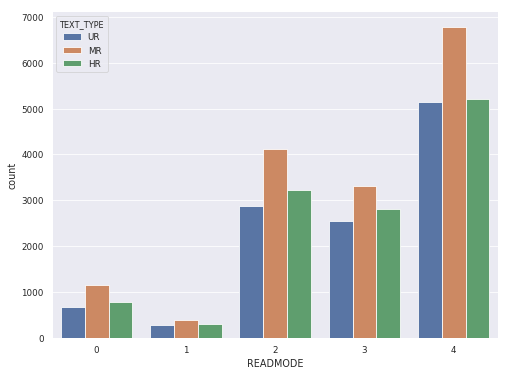

In [85]:
plt.figure(figsize=(8, 6))
sns.set_context("paper", font_scale=1.0)   
ax = sns.countplot(x="READMODE", hue="TEXT_TYPE", data=df)

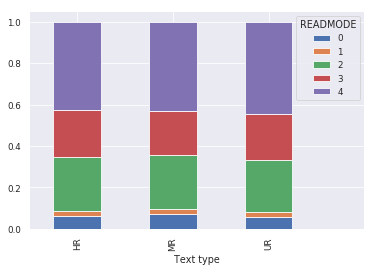

In [86]:
props = df.groupby("TEXT_TYPE")['READMODE'].value_counts(normalize=True).unstack()
ax = props.plot(kind='bar', stacked='True')
ax.axes.set_xlabel("Text type")
ax.axes.set_xbound((ax.axes.get_xbound()[0],1.2*ax.axes.get_xbound()[1]))


# plt.show()

if save_images:
    plt.savefig(image_path + os.sep + "readmode_per_text_type.svg", format="svg")

In [87]:
# Number of fixations per text type
df.groupby("TEXT_TYPE")['READMODE'].value_counts(normalize=False).unstack().sum(axis=1)

TEXT_TYPE
HR    12316
MR    15745
UR    11503
dtype: int64

In [88]:
# Select READMODE variable
df_RMD = df[['TEXT_TYPE','TEXT_NO','SUBJ','READMODE']]

In [89]:
RMD_file = os.path.join(tempdir, 'rmd_file.csv')
df_RMD.to_csv(RMD_file)

__Remark:__ The lines below can be discarded (up to HSMCs) but its is recommended to run every line above.

In [90]:
%%R -i RMD_file
if(!require(MCMCglmm)){
    install.packages("MCMCglmm")
    library(MCMCglmm)
}

df_RMD = read.table(RMD_file, sep=",", header=TRUE, row.names=1)
names(df_RMD) = c("TEXT_TYPE", "TEXT_NO", "SUBJ", "READMODE")
df_RMD$TEXT_NO = factor(df_RMD$TEXT_NO)
df_RMD$SUBJ = factor(df_RMD$SUBJ)
df_RMD$READMODE = factor(df_RMD$READMODE)

set.seed(0)
mod_rmd_ran = MCMCglmm(READMODE ~ trait + TEXT_TYPE:trait, random = ~SUBJ, rcov=~idh(trait):units,data = df_RMD, family="categorical")
summary(mod_rmd_ran)

/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: MCMCglmm

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: coda

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: ape

  warnings.warn(x, RRuntimeWarning)



                       MCMC iteration = 0

 Acceptance ratio for liability set 1 = 0.000314

                       MCMC iteration = 1000

 Acceptance ratio for liability set 1 = 0.258338

                       MCMC iteration = 2000

 Acceptance ratio for liability set 1 = 0.264557

                       MCMC iteration = 3000

 Acceptance ratio for liability set 1 = 0.265970

                       MCMC iteration = 4000

 Acceptance ratio for liability set 1 = 0.315039

                       MCMC iteration = 5000

 Acceptance ratio for liability set 1 = 0.319174

                       MCMC iteration = 6000

 Acceptance ratio for liability set 1 = 0.323171

                       MCMC iteration = 7000

 Acceptance ratio for liability set 1 = 0.309541

                       MCMC iteration = 8000

 Acceptance ratio for liability set 1 = 0.289658

                       MCMC iteration = 9000

 Acceptance ratio for liability set 1 = 0.262602

                       MCMC iteration = 10

In [91]:
%%R 
print(mod_rmd_ran$DIC)

[1] 101235.7


In [92]:
%%R 
prob = 0.995
HPDinterval(mcmc(mod_rmd_ran$VCV)[,"SUBJ"], prob)


         lower    upper
var1 0.2158921 2.348559
attr(,"Probability")
[1] 0.995


Model with no random subject-related effect 

In [93]:
%%R 

set.seed(0)
mod_rmd_f = MCMCglmm(READMODE ~ trait + TEXT_TYPE:trait, rcov=~idh(trait):units,data = df_RMD, family="categorical")
summary(mod_rmd_f)


                       MCMC iteration = 0

 Acceptance ratio for liability set 1 = 0.000318

                       MCMC iteration = 1000

 Acceptance ratio for liability set 1 = 0.266315

                       MCMC iteration = 2000

 Acceptance ratio for liability set 1 = 0.269310

                       MCMC iteration = 3000

 Acceptance ratio for liability set 1 = 0.268088

                       MCMC iteration = 4000

 Acceptance ratio for liability set 1 = 0.245478

                       MCMC iteration = 5000

 Acceptance ratio for liability set 1 = 0.241380

                       MCMC iteration = 6000

 Acceptance ratio for liability set 1 = 0.226607

                       MCMC iteration = 7000

 Acceptance ratio for liability set 1 = 0.211269

                       MCMC iteration = 8000

 Acceptance ratio for liability set 1 = 0.208973

                       MCMC iteration = 9000

 Acceptance ratio for liability set 1 = 0.211090

                       MCMC iteration = 10

Increase in DIC shows significance of random effects (the LOWER DIC, the better)

In [94]:
%%R 
print(mod_rmd_f$DIC)

[1] 102912.5


NULL model: no TEXT_TYPE effect

In [95]:
%%R 

set.seed(0)
mod_rmd_NULL = MCMCglmm(READMODE ~ trait, random = ~SUBJ, rcov=~idh(trait):units,data = df_RMD, family="categorical")
summary(mod_rmd_NULL)


                       MCMC iteration = 0

 Acceptance ratio for liability set 1 = 0.000336

                       MCMC iteration = 1000

 Acceptance ratio for liability set 1 = 0.262049

                       MCMC iteration = 2000

 Acceptance ratio for liability set 1 = 0.262456

                       MCMC iteration = 3000

 Acceptance ratio for liability set 1 = 0.269289

                       MCMC iteration = 4000

 Acceptance ratio for liability set 1 = 0.235134

                       MCMC iteration = 5000

 Acceptance ratio for liability set 1 = 0.225867

                       MCMC iteration = 6000

 Acceptance ratio for liability set 1 = 0.216382

                       MCMC iteration = 7000

 Acceptance ratio for liability set 1 = 0.214795

                       MCMC iteration = 8000

 Acceptance ratio for liability set 1 = 0.206528

                       MCMC iteration = 9000

 Acceptance ratio for liability set 1 = 0.215017

                       MCMC iteration = 10

NULL model with no random effect

In [96]:
%%R 

set.seed(0)
mod_rmd_f_NULL = MCMCglmm(READMODE ~ trait, rcov=~idh(trait):units,data = df_RMD, family="categorical")
summary(mod_rmd_f_NULL)


                       MCMC iteration = 0

 Acceptance ratio for liability set 1 = 0.000343

                       MCMC iteration = 1000

 Acceptance ratio for liability set 1 = 0.259120

                       MCMC iteration = 2000

 Acceptance ratio for liability set 1 = 0.266196

                       MCMC iteration = 3000

 Acceptance ratio for liability set 1 = 0.267324

                       MCMC iteration = 4000

 Acceptance ratio for liability set 1 = 0.206590

                       MCMC iteration = 5000

 Acceptance ratio for liability set 1 = 0.209145

                       MCMC iteration = 6000

 Acceptance ratio for liability set 1 = 0.201709

                       MCMC iteration = 7000

 Acceptance ratio for liability set 1 = 0.207031

                       MCMC iteration = 8000

 Acceptance ratio for liability set 1 = 0.199833

                       MCMC iteration = 9000

 Acceptance ratio for liability set 1 = 0.199292

                       MCMC iteration = 10

The effect of text type on READMODE distribution per scanpath is considered (Bayesian multinomial regression model).  
Testing significance of random individual effect (0.995-CI: 0.2614709 2.574577): significant individual effect.  
DIC values (to be minimized):  
DIC value (GLMM mod_rmd_ran): 100299.9  
DIC value (GLM mod_rmd_f, no random effect): 100870.7 (somewhat significant random individual effect)  
DIC value (GLMM without text effect mod_rmd_NULL): 99752.67 (no text type effect)  
DIC value (GLMM without text effect nor individual random effect mod_rmd_NULL): 102553.8 (no text type effect)  
Eventually there seems to be an individual effect only (no effect of TEXT_TYPE), which is kind of counter-intuitive given the significance of individual parameters, particularly more READMODE4 Fwd++ in UR. This can be explained by predominance of individual variability.

In [97]:
%%R 
print(mod_rmd_NULL$DIC)

[1] 101283.1


## Model estimation

In [98]:
# Hacking Model.update_restored_data 
def update_restored_data(self):
    """Update restaured data after running estimate."""
    restored_data = self.hsmm.extract_data()
    self.eye_movement_data.restored_data = self.eye_movement_data.assign(
        STATES=[fixation[0] for text_reading in restored_data for fixation in text_reading])
    self.eye_movement_data.restored_data['PHASE'] = self.eye_movement_data.restored_data.STATES
    self.eye_movement_data.restored_data.at[self.eye_movement_data.restored_data.PHASE < 2, 'PHASE'] = 1
    self.eye_movement_data.restored_data.at[self.eye_movement_data.restored_data.PHASE == 2, 'PHASE'] = 2
    self.eye_movement_data.restored_data.at[self.eye_movement_data.restored_data.PHASE == 3, 'PHASE'] = 3
    self.eye_movement_data.restored_data.at[self.eye_movement_data.restored_data.PHASE == 4, 'PHASE'] = 4

In [99]:
Model.update_restored_data = update_restored_data

In [100]:
output_path = os.getcwd() + os.sep + "tmp_dir"

if not os.path.exists(output_path):
    os.mkdir(output_path)
    
init_path = os.path.join(MODEL_PATH, 'model3_init5abs_rev_v2.hsmc')
model = Model(df, init_hsmc_file=init_path, output_path=output_path)
model.iterate_em(3500)
model.hsmm.save(os.path.join(tempdir, 'hf_rm1_ki_5.hsmc'))
model.print_hsmc_file(verbose=False)

/mnt/devlp/PyENE-analysis/notebooks/tmp_dir/JJCsgv.hsmc
HIDDEN_SEMI-MARKOV_CHAIN

5 STATES

INITIAL_PROBABILITIES

0.519235     0.230248     0.011598     0.238909     9.99999999995e-06

TRANSITION_PROBABILITIES

0.0     0.99997     1e-05     1e-05     1.00000000001e-05

0.763324     0.0     0.156121     0.012254     0.068301

0.0     0.99998     0.0     1e-05     1.00000000001e-05

0.0     0.0     0.0     0.0     1.0

0.0     0.0     0.0     0.0     1.0

STATE 0 OCCUPANCY_DISTRIBUTION

BINOMIAL   INF_BOUND : 1   SUP_BOUND : 4   PROBABILITY : 0.0981719

STATE 1 OCCUPANCY_DISTRIBUTION

BINOMIAL   INF_BOUND : 1   SUP_BOUND : 5   PROBABILITY : 0.0555402

STATE 2 OCCUPANCY_DISTRIBUTION

NEGATIVE_BINOMIAL   INF_BOUND : 1   PARAMETER : 0.680105   PROBABILITY : 0.214574

STATE 3 OCCUPANCY_DISTRIBUTION

NEGATIVE_BINOMIAL   INF_BOUND : 1   PARAMETER : 41.1753   PROBABILITY : 0.769047

1 OUTPUT_PROCESS

OUTPUT_PROCESS 1 : CATEGORICAL

STATE 0 OBSERVATION_DISTRIBUTION

OUTPUT 0 : 0.0084

OUTPUT 1 

States 0/1 (phase 1): normal reading NR  
State 2 (phase 2): information search IS  
State 3 (phase 3): fast reading FR  
State 4 (phase 4): slow confirmation SC  

## State restoration

### Empirical initial probabilities

In [101]:
rseqs = model.hsmm.extract_data()
np.set_printoptions(precision=2, suppress=True)

empirical_pi = np.zeros(5)
for seq in rseqs:
    empirical_pi[seq[0][0]] +=1
    
print(empirical_pi)
print(empirical_pi / empirical_pi.sum())

[ 1216.   336.     3.   835.     0.]
[ 0.51  0.14  0.    0.35  0.  ]


### Empirical final probabilities

In [102]:
last_pi = np.zeros(5)
for seq in rseqs:
    last_pi[seq[-1][0]] +=1
    
print(last_pi)
print(last_pi / last_pi.sum())

[ 383.  446.  167.  637.  757.]
[ 0.16  0.19  0.07  0.27  0.32]


### Empirical transition probabilities

In [103]:
empirical_A = np.zeros((5,5))
for seq in rseqs:
    last_state = -1
    current_state = -1
    for elem in seq:
        current_state = elem[0]
        if (last_state != -1) & (current_state != last_state):
            empirical_A[last_state, current_state] +=1
        last_state = current_state
print(empirical_A)
freq_A = np.array(empirical_A)
for i in range(5):
    freq_A[i] = freq_A[i] / freq_A[i].sum()
print(freq_A)    

[[    0.  7265.     0.     0.     0.]
 [ 6432.     0.   452.     5.   554.]
 [    0.   288.     0.     0.     0.]
 [    0.     0.     0.     0.   203.]
 [    0.     0.     0.     0.     0.]]
[[ 0.    1.    0.    0.    0.  ]
 [ 0.86  0.    0.06  0.    0.07]
 [ 0.    1.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    1.  ]
 [  nan   nan   nan   nan   nan]]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in divide
  del sys.path[0]


### Empirical emission probabilities

In [104]:
empirical_B = np.zeros((5,5))
for seq in rseqs:
    for elem in seq:
        empirical_B[elem[0], elem[1]] +=1
print(empirical_B)
freq_B = np.array(empirical_B)
for i in range(5):
    freq_B[i] = freq_B[i] / freq_B[i].sum()
print(freq_B)   

[[   10.   208.  6830.  3017.     0.]
 [    4.    66.    43.  1857.  6800.]
 [  394.     0.   608.     0.   642.]
 [  213.   217.  1042.  2493.  5345.]
 [ 1961.   475.  1677.  1304.  4358.]]
[[ 0.    0.02  0.68  0.3   0.  ]
 [ 0.    0.01  0.    0.21  0.78]
 [ 0.24  0.    0.37  0.    0.39]
 [ 0.02  0.02  0.11  0.27  0.57]
 [ 0.2   0.05  0.17  0.13  0.45]]


## Graphical synthesis with some scanpaths

In [105]:
if not os.path.exists(output_path):
    os.mkdir(output_path)
report = html_report.Htmlreport(model, number_of_text_restorations_to_display=1000, phase=True, png_path=PNG_PATH, output_path=output_path)
report.make_html(True)

('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. D

('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. D

('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. D

('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. D

('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. D

('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. D

('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. D

('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. D

('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. D

('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. D

('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. D

('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. D

('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. D

('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. D

('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. D

('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)
('TrueType font arial.ttf could not be loaded. D

In [106]:
print("Report printed in " + str(report._html_report_file_path))

Report printed in /mnt/devlp/PyENE-analysis/notebooks/tmp_dir/JJCsgv-report.html


In [107]:
rdf = model.eye_movement_data.restored_data

#### Example to plot a specific scanpath, if needed

In [108]:
subj_text_list = rdf[['SUBJ_NAME', 'TEXT']].groupby(['SUBJ_NAME', 'TEXT']).count().reset_index()
subj_text_list.head()

SUBJ_NAME              TEXT
0       s01  aide_refugies-a1
1       s01  aide_refugies-a2
2       s01  aide_refugies-f1
3       s01  aide_refugies-f2
4       s01  aide_refugies-m1

In [109]:
import visuscanpath
import unidecode

In [110]:
# Find a given scanpath by subject and text
subject = "s01"
text = "chasse_oiseaux-a1"
f = [i for i in range(subj_text_list.shape[0]) if (subj_text_list.iloc[i].SUBJ_NAME == subject and subj_text_list.iloc[i].TEXT == text)]
if len(f) > 0:
    i = f[0]
else:
    print("Scanpath not found")

('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)


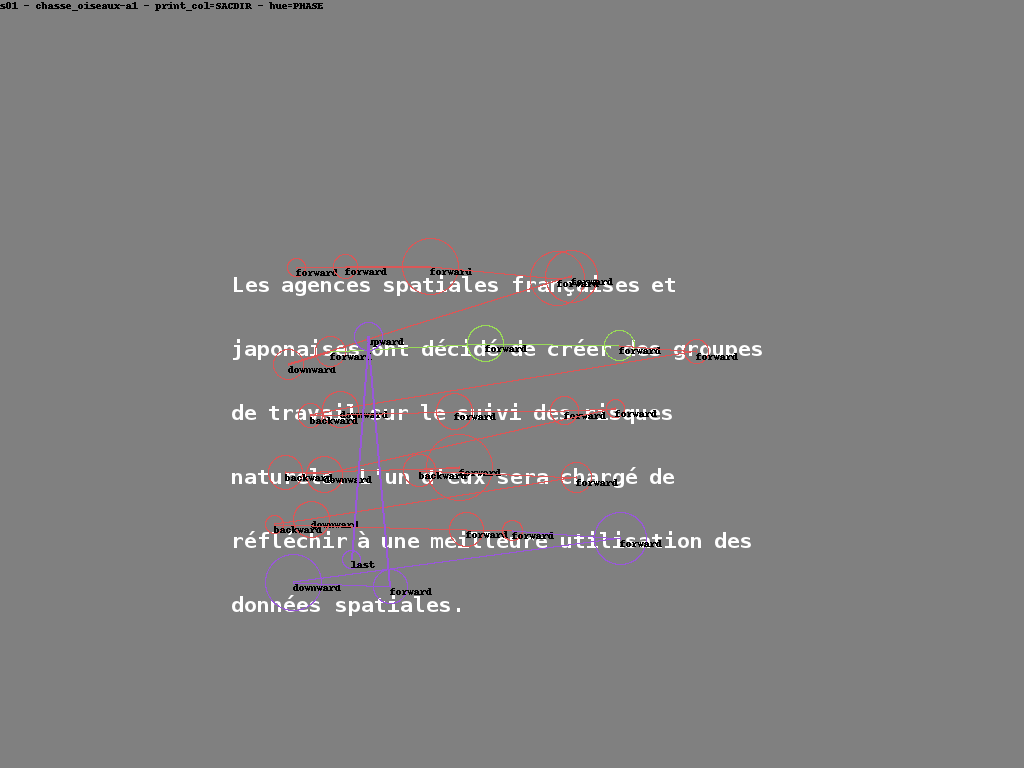

In [111]:
visuscanpath.plot_scanpath(dataframe=model.eye_movement_data.restored_data, 
                           display=False,
                           img_path=os.path.join(report._png_path,
                                                 unidecode.unidecode(subj_text_list.loc[i][1]) + ".png"),
                           subject=subj_text_list.loc[i][0],
                           text_name=subj_text_list.loc[i][1],
                           hue='PHASE',
                           print_col = 'SACDIR',
                           output_file=os.path.join(report._output_path, report._model.model_id + "-subj-" +
                                                    subj_text_list.loc[i][0] +
                                                    "-text-" +
                                                    unidecode.unidecode(subj_text_list.loc[i][1]) + ".png"))

In [112]:
rdf[['PHASE']].loc[pd.Series(rdf['SUBJ']==1) & pd.Series(rdf['TEXT']=='chasse_oiseaux-a1')].transpose()

0   1   2   3   4   5   6   7   8   9  ...  19  20  21  22  23  24  25  \
PHASE   1   1   1   1   1   1   1   2   2   1 ...   1   1   1   1   1   4   4   

       26  27  28  
PHASE   4   4   4  

[1 rows x 29 columns]

In [113]:
# Find a given scanpath by subject and text
subject = "s01"
text = "chasse_oiseaux-a2"
f = [i for i in range(subj_text_list.shape[0]) if (subj_text_list.iloc[i].SUBJ_NAME == subject and subj_text_list.iloc[i].TEXT == text)]
if len(f) > 0:
    i = f[0]
else:
    print("Scanpath not found")

('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)


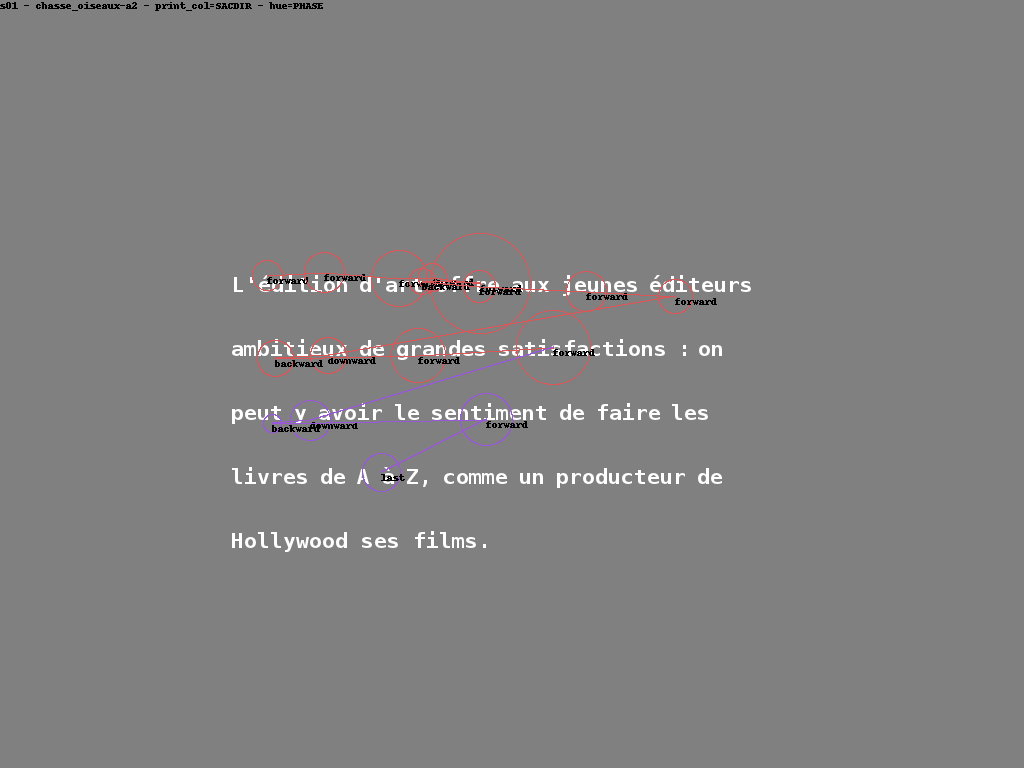

In [114]:
visuscanpath.plot_scanpath(dataframe=model.eye_movement_data.restored_data, 
                           display=False,
                           img_path=os.path.join(report._png_path,
                                                 unidecode.unidecode(subj_text_list.loc[i][1]) + ".png"),
                           subject=subj_text_list.loc[i][0],
                           text_name=subj_text_list.loc[i][1],
                           hue='PHASE',
                           print_col = 'SACDIR',
                           output_file=os.path.join(report._output_path, report._model.model_id + "-subj-" +
                                                    subj_text_list.loc[i][0] +
                                                    "-text-" +
                                                    unidecode.unidecode(subj_text_list.loc[i][1]) + ".png"))

In [115]:
rdf[['PHASE']].loc[pd.Series(rdf['SUBJ']==1) & pd.Series(rdf['TEXT']=='chasse_oiseaux-a2')].transpose()

29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
PHASE   1   1   1   1   1   1   1   1   1   1   1   1   1   4   4   4   4

In [116]:
# Find a given scanpath by subject and text
subject = "s01"
text = "tourisme_montagne-a2"
f = [i for i in range(subj_text_list.shape[0]) if (subj_text_list.iloc[i].SUBJ_NAME == subject and subj_text_list.iloc[i].TEXT == text)]
if len(f) > 0:
    i = f[0]
else:
    print("Scanpath not found")

('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)


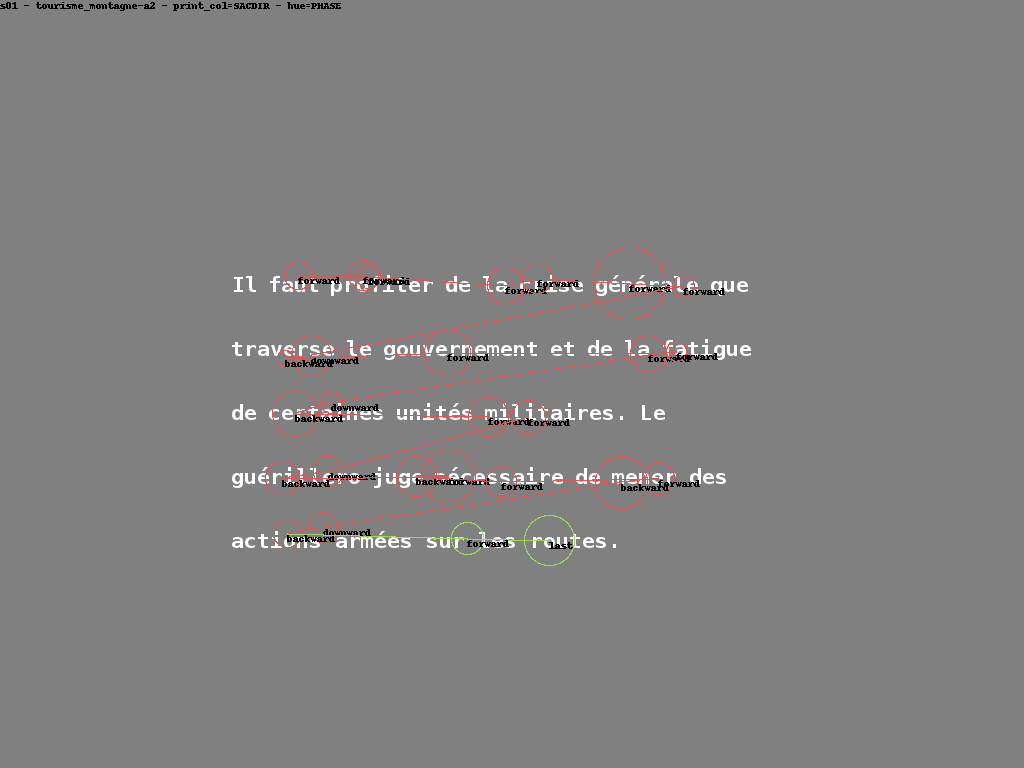

In [117]:
visuscanpath.plot_scanpath(dataframe=model.eye_movement_data.restored_data, 
                           display=False,
                           img_path=os.path.join(report._png_path,
                                                 unidecode.unidecode(subj_text_list.loc[i][1]) + ".png"),
                           subject=subj_text_list.loc[i][0],
                           text_name=subj_text_list.loc[i][1],
                           hue='PHASE',
                           print_col = 'SACDIR',
                           output_file=os.path.join(report._output_path, report._model.model_id + "-subj-" +
                                                    subj_text_list.loc[i][0] +
                                                    "-text-" +
                                                    unidecode.unidecode(subj_text_list.loc[i][1]) + ".png"))

In [118]:
rdf[['PHASE']].loc[pd.Series(rdf['SUBJ']==1) & pd.Series(rdf['TEXT']=='tourisme_montagne-a2')].transpose()

105  106  107  108  109  110  111  112  113  114 ...   122  123  124  \
PHASE    1    1    1    1    1    1    1    1    1    1 ...     1    1    1   

       125  126  127  128  129  130  131  
PHASE    1    1    1    1    1    2    2  

[1 rows x 27 columns]

In [119]:
# Find a given scanpath by subject and text
subject = "s01"
text = "aide_refugies-a2"
f = [i for i in range(subj_text_list.shape[0]) if (subj_text_list.iloc[i].SUBJ_NAME == subject and subj_text_list.iloc[i].TEXT == text)]
if len(f) > 0:
    i = f[0]
else:
    print("Scanpath not found")

('TrueType font arial.ttf could not be loaded. Default will be used instead.', <ipykernel.iostream.OutStream object at 0x7f8fd0e1d9d0>)


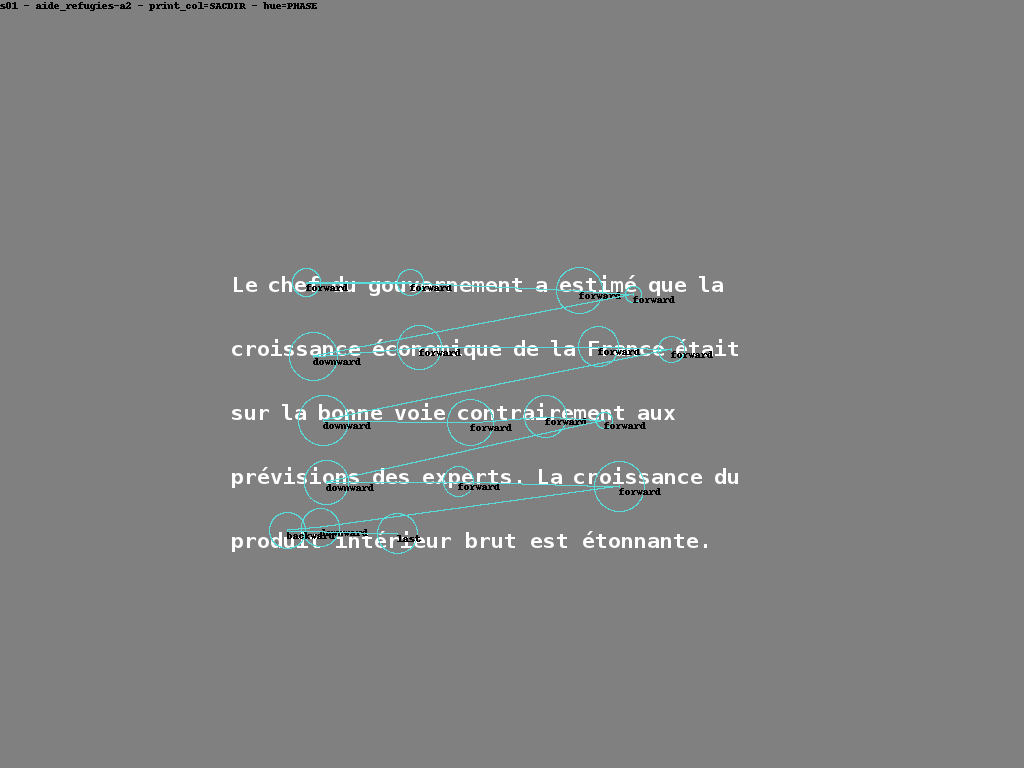

In [120]:
visuscanpath.plot_scanpath(dataframe=model.eye_movement_data.restored_data, 
                           display=False,
                           img_path=os.path.join(report._png_path,
                                                 unidecode.unidecode(subj_text_list.loc[i][1]) + ".png"),
                           subject=subj_text_list.loc[i][0],
                           text_name=subj_text_list.loc[i][1],
                           hue='PHASE',
                           print_col = 'SACDIR',
                           output_file=os.path.join(report._output_path, report._model.model_id + "-subj-" +
                                                    subj_text_list.loc[i][0] +
                                                    "-text-" +
                                                    unidecode.unidecode(subj_text_list.loc[i][1]) + ".png"))

In [121]:
rdf[['PHASE']].loc[pd.Series(rdf['SUBJ']==1) & pd.Series(rdf['TEXT']=='aide_refugies-a2')].transpose()

454  455  456  457  458  459  460  461  462  463  464  465  466  467  \
PHASE    3    3    3    3    3    3    3    3    3    3    3    3    3    3   

       468  469  470  471  
PHASE    3    3    3    3

## Entropy and state profiles (state uncertainty)

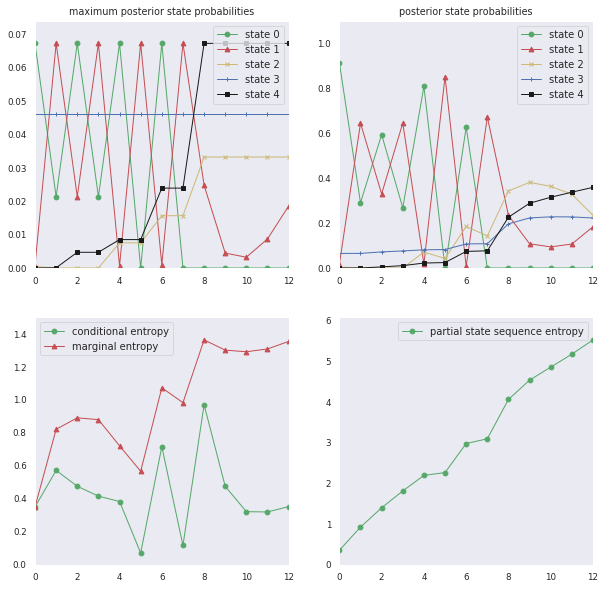

In [122]:
Plot(model.hsmm, 7, ViewPoint="StateProfile")

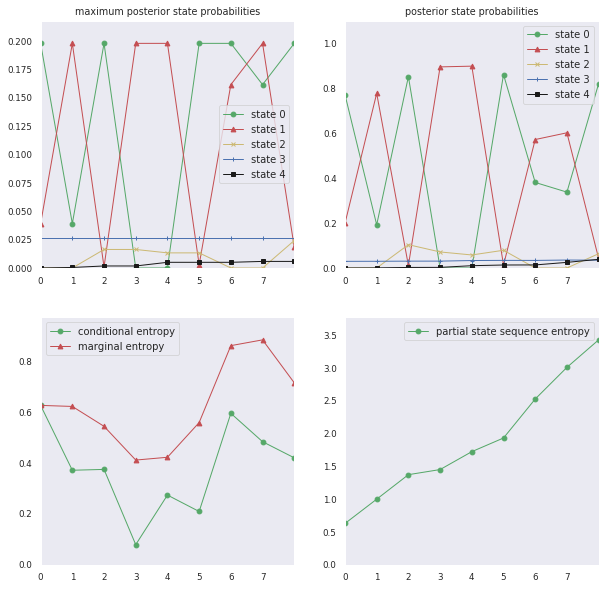

In [123]:
Plot(model.hsmm, 8, ViewPoint="StateProfile")

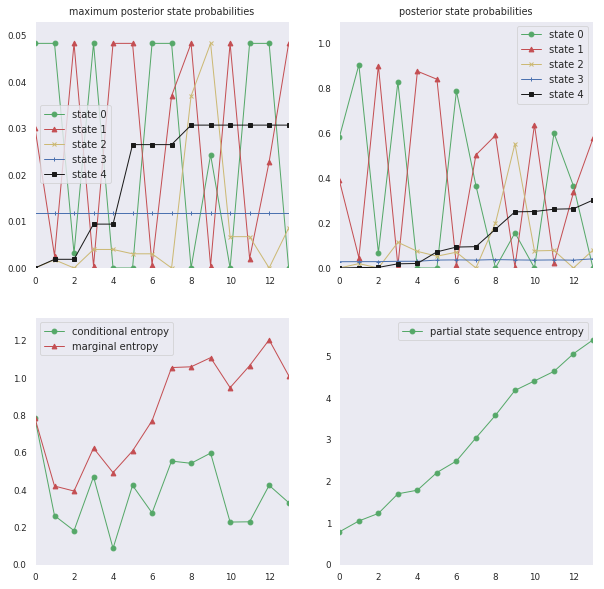

In [124]:
Plot(model.hsmm, 9, ViewPoint="StateProfile")

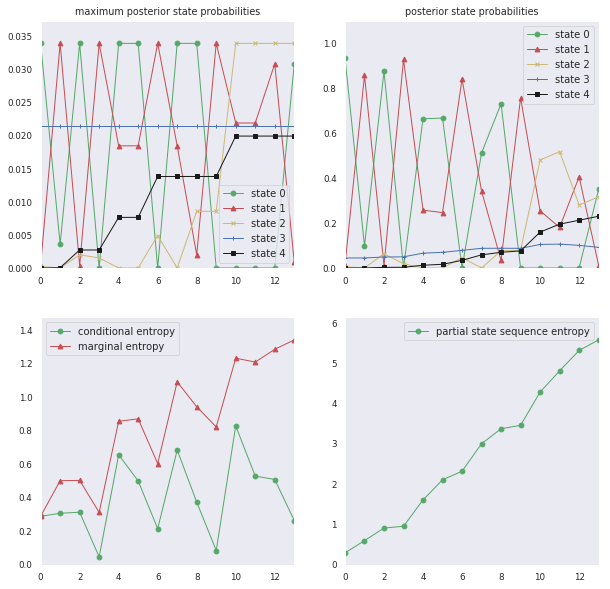

In [125]:
Plot(model.hsmm, 10, ViewPoint="StateProfile")

## Other post processing using states:

### frequencies of states

In [126]:
# Number of states
nb_states = len(set(rdf.STATES))
rdf[['STATES']].apply(pd.value_counts) / rdf.shape[0]

STATES
0  0.254398
4  0.247068
3  0.235315
1  0.221666
2  0.041553

In [127]:
sns.set_context("notebook", font_scale=1.5);

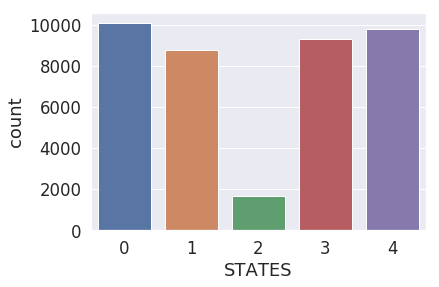

In [128]:
sns.countplot(x=rdf.STATES);

if save_images:
    plt.savefig(image_path + os.sep + "state_marginal.svg", format="svg")

### frequencies of phases

In [129]:
# Number of states
rdf[['PHASE']].apply(pd.value_counts) / rdf.shape[0]
nb_phases = len(set(rdf.PHASE))

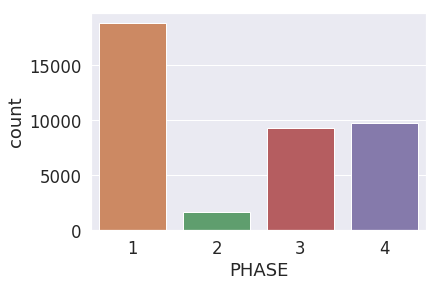

In [130]:
sns.countplot(x=rdf.PHASE, palette=sns.color_palette()[1:]);

if save_images:
    plt.savefig(image_path + os.sep + "phase_marginal.svg", format="svg")

### frequencies of states per text type (including HR+)

In [131]:
rdf_type_state = rdf.groupby('TEXT_TYPE_2')['STATES'].value_counts()
print(rdf_type_state)
rdf.groupby('TEXT_TYPE_2')['STATES'].value_counts() / rdf.groupby('TEXT_TYPE_2')['STATES'].count()

TEXT_TYPE_2  STATES
HR           0         1765
             3         1642
             4         1502
             1         1495
             2          233
HR+          0         1477
             4         1323
             1         1289
             3         1285
             2          305
MR           4         4534
             0         3920
             1         3499
             3         3175
             2          617
UR           3         3208
             0         2903
             1         2487
             4         2416
             2          489
Name: STATES, dtype: int64


TEXT_TYPE_2  STATES
HR           0         0.265933
             3         0.247401
             4         0.226307
             1         0.225252
             2         0.035106
HR+          0         0.260081
             4         0.232964
             1         0.226977
             3         0.226272
             2         0.053707
MR           4         0.287964
             0         0.248968
             1         0.222229
             3         0.201651
             2         0.039187
UR           3         0.278884
             0         0.252369
             1         0.216204
             4         0.210032
             2         0.042511
Name: STATES, dtype: float64

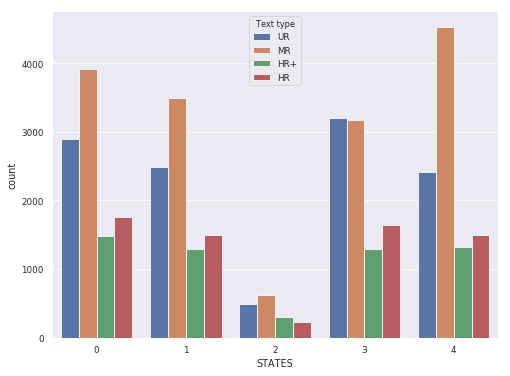

In [132]:
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text

plt.figure(figsize=(8, 6))
sns.set_context("paper", font_scale=1.0)   
ax = sns.countplot(x="STATES", hue="TEXT_TYPE_2", data=rdf)

ax.legend_.set_title('Text type')
plt.show()
 

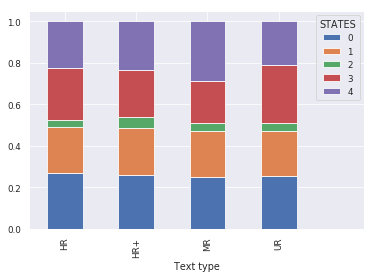

In [133]:
props = rdf.groupby("TEXT_TYPE_2")['STATES'].value_counts(normalize=True).unstack()
ax = props.plot(kind='bar', stacked='True')
ax.axes.set_xlabel("Text type")
ax.axes.set_xbound((ax.axes.get_xbound()[0],1.2*ax.axes.get_xbound()[1]))

if save_images:
    plt.savefig(image_path + os.sep + "states_per_text_type.svg", format="svg")

### frequencies of phases per text type

In [134]:
rdf_type_phase = rdf.groupby('TEXT_TYPE_2')['PHASE'].value_counts()
print(rdf_type_phase)
# rdf_type_phase.to_csv(PLOTS_PATH + os.sep + 'rdf_type_phase.csv', index=None, encoding='utf-8')
rdf.groupby('TEXT_TYPE_2')['PHASE'].value_counts() / rdf.groupby('TEXT_TYPE_2')['PHASE'].count()

TEXT_TYPE_2  PHASE
HR           1        3260
             3        1642
             4        1502
             2         233
HR+          1        2766
             4        1323
             3        1285
             2         305
MR           1        7419
             4        4534
             3        3175
             2         617
UR           1        5390
             3        3208
             4        2416
             2         489
Name: PHASE, dtype: int64


TEXT_TYPE_2  PHASE
HR           1        0.491186
             3        0.247401
             4        0.226307
             2        0.035106
HR+          1        0.487058
             4        0.232964
             3        0.226272
             2        0.053707
MR           1        0.471197
             4        0.287964
             3        0.201651
             2        0.039187
UR           1        0.468573
             3        0.278884
             4        0.210032
             2        0.042511
Name: PHASE, dtype: float64

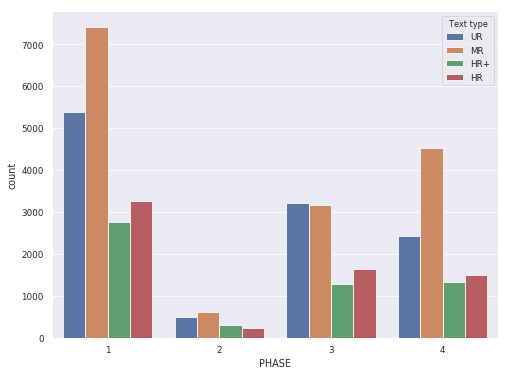

In [135]:
plt.figure(figsize=(8, 6))
sns.set_context("paper", font_scale=1.0)   
ax = sns.countplot(x="PHASE", hue="TEXT_TYPE_2", data=rdf)

ax.legend_.set_title('Text type')
plt.show() 

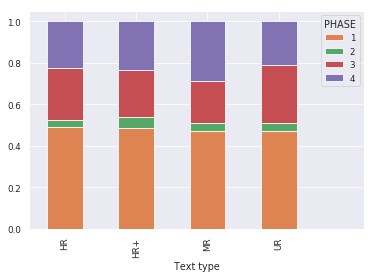

In [136]:
pprops = rdf.groupby("TEXT_TYPE_2")['PHASE'].value_counts(normalize=True).unstack()
ax = pprops.plot(kind='bar', stacked='True', color=sns.color_palette()[1:])
ax.axes.set_xlabel("Text type")
ax.axes.set_xbound((ax.axes.get_xbound()[0],1.2*ax.axes.get_xbound()[1]))

if save_images:
    plt.savefig(image_path + os.sep + "phase_per_text_type.svg", format="svg")

In [137]:
# Select READMODE variable
rdf_PHASE = rdf[['TEXT_TYPE_2','SUBJ','PHASE']]

In [138]:
PHS_file = os.path.join(tempdir, 'phs_file.csv')
rdf_PHASE.to_csv(PHS_file)

Effect of text type2 on phase distribution

In [139]:
%%R -i RMD_file
if(!require(MCMCglmm)){
    install.packages("MCMCglmm")
    library(MCMCglmm)
}


In [140]:
%%R -i PHS_file

rdf_PHASE = read.table(PHS_file, sep=",", header=TRUE, row.names=1)
rdf_PHASE$SUBJ = factor(rdf_PHASE$SUBJ)
rdf_PHASE$PHASE = factor(rdf_PHASE$PHASE)
unique(rdf_PHASE$PHASE)

[1] 1 2 4 3
Levels: 1 2 3 4


In [141]:
%%R -i PHS_file

rdf_PHASE = read.table(PHS_file, sep=",", header=TRUE, row.names=1)
rdf_PHASE$SUBJ = factor(rdf_PHASE$SUBJ)
rdf_PHASE$PHASE = factor(rdf_PHASE$PHASE)

set.seed(0)
mod_phs_ran = MCMCglmm(PHASE ~ trait + TEXT_TYPE_2:trait, random = ~SUBJ, rcov=~idh(trait):units,data = rdf_PHASE, family="categorical", pr=TRUE)
summary(mod_phs_ran)



                       MCMC iteration = 0

 Acceptance ratio for liability set 1 = 0.000384

                       MCMC iteration = 1000

 Acceptance ratio for liability set 1 = 0.278924

                       MCMC iteration = 2000

 Acceptance ratio for liability set 1 = 0.277386

                       MCMC iteration = 3000

 Acceptance ratio for liability set 1 = 0.284172

                       MCMC iteration = 4000

 Acceptance ratio for liability set 1 = 0.247285

                       MCMC iteration = 5000

 Acceptance ratio for liability set 1 = 0.238199

                       MCMC iteration = 6000

 Acceptance ratio for liability set 1 = 0.215057

                       MCMC iteration = 7000

 Acceptance ratio for liability set 1 = 0.203439

                       MCMC iteration = 8000

 Acceptance ratio for liability set 1 = 0.188050

                       MCMC iteration = 9000

 Acceptance ratio for liability set 1 = 0.174047

                       MCMC iteration = 10

In [142]:
%%R 
print(mod_phs_ran$DIC)

[1] 78598.36


Histogram and credible interval for random effect sdev

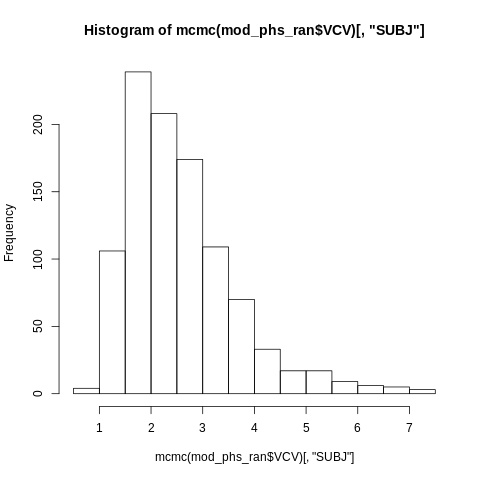

In [143]:
%%R 
hist(mcmc(mod_phs_ran$VCV)[,"SUBJ"])


In [144]:
%%R 
prob = 0.995
HPDinterval(mcmc(mod_phs_ran$VCV)[,"SUBJ"], prob)


        lower    upper
var1 0.834565 6.740688
attr(,"Probability")
[1] 0.995


Model with no random subject-related effect
(shows significance of subject effects)

In [145]:
%%R 

set.seed(0)
mod_phs_f = MCMCglmm(PHASE ~ trait + TEXT_TYPE_2:trait, rcov=~idh(trait):units,data = rdf_PHASE, family="categorical")
summary(mod_phs_f)


                       MCMC iteration = 0

 Acceptance ratio for liability set 1 = 0.000387

                       MCMC iteration = 1000

 Acceptance ratio for liability set 1 = 0.281626

                       MCMC iteration = 2000

 Acceptance ratio for liability set 1 = 0.278446

                       MCMC iteration = 3000

 Acceptance ratio for liability set 1 = 0.286751

                       MCMC iteration = 4000

 Acceptance ratio for liability set 1 = 0.268979

                       MCMC iteration = 5000

 Acceptance ratio for liability set 1 = 0.296889

                       MCMC iteration = 6000

 Acceptance ratio for liability set 1 = 0.298707

                       MCMC iteration = 7000

 Acceptance ratio for liability set 1 = 0.314388

                       MCMC iteration = 8000

 Acceptance ratio for liability set 1 = 0.309577

                       MCMC iteration = 9000

 Acceptance ratio for liability set 1 = 0.327281

                       MCMC iteration = 10

In [146]:
%%R 
print(mod_phs_f$DIC)

[1] 91731.28


NULL model: no TEXT_TYPE effect
(shows moderate significance of type of text ?)

In [147]:
%%R 

set.seed(0)
mod_phs_NULL = MCMCglmm(PHASE ~ trait, random = ~SUBJ, rcov=~idh(trait):units,data = rdf_PHASE, family="categorical")
summary(mod_phs_NULL)


                       MCMC iteration = 0

 Acceptance ratio for liability set 1 = 0.000409

                       MCMC iteration = 1000

 Acceptance ratio for liability set 1 = 0.277570

                       MCMC iteration = 2000

 Acceptance ratio for liability set 1 = 0.277920

                       MCMC iteration = 3000

 Acceptance ratio for liability set 1 = 0.284044

                       MCMC iteration = 4000

 Acceptance ratio for liability set 1 = 0.267971

                       MCMC iteration = 5000

 Acceptance ratio for liability set 1 = 0.247647

                       MCMC iteration = 6000

 Acceptance ratio for liability set 1 = 0.235252

                       MCMC iteration = 7000

 Acceptance ratio for liability set 1 = 0.216103

                       MCMC iteration = 8000

 Acceptance ratio for liability set 1 = 0.194240

                       MCMC iteration = 9000

 Acceptance ratio for liability set 1 = 0.179434

                       MCMC iteration = 10

In [148]:
%%R 
print(mod_phs_NULL$DIC)

[1] 78853.66


In [149]:
os.remove(PHS_file)

The effect of text type2 on PHASE distribution per scanpath is considered  
Testing individual random effect (0.995-CI 0.8485355 6.489118): significant individual effect.  
DIC values (to be minimized):  
DIC value (mixed model mod_phs_ran): 78489.28  
DIC value (GLM mod_phs_f):  91662.97 (strong individual effect)  
DIC value (GLMM without text type2 effect mod_phs_NULL): 78955.1 Strong text type2 effect  
(MR: more phase 4 SC, less phase 3 FR; UR: less phase 1 NR, more phase 2 IS and 3 FR; HR+ more phase 2 and 4 SC)

In [150]:
78489.28  - 78955.1

-465.820000000007

__Number of fixations per subject and text number__ <br>
__Note that some text numbers have almost no trial, some subjects have a lot of missing text numbers__

Connexion between TEXT_NO and TEXT <br>
TEXT_NO should be the order of presentation of some given TEXT

In [151]:
# Number of 'TEXT' for 'TEXT_NO' == 1
print(set(rdf[rdf['TEXT_NO']==1]['TEXT']))
print(len(set(rdf[rdf['TEXT_NO']==1]['TEXT'])))

set([u'reforme_justice-f1', u'croissance_economie-f2', u'dechets_nucleaires-f2', u'salon_aeronautique-a1', u'decollage_fusee-f2', u'conflit_israelo_palestinien-m2', u'rehabilitation_logement-f1', u'allocation_familiale-a2', u'chasse_oiseaux-a1', u'chasse_oiseaux-m2', u'dechets_nucleaires-m2', u'decollage_fusee-m1', u'conflit_israelo_palestinien-f1', u'rehabilitation_logement-m1', u'salon_aeronautique-f1', u'croissance_economie-a2', u'croissance_economie-a1', u'faiblesse_dollar-f1', u'dechets_nucleaires-a2', u'dechets_nucleaires-a1', u'decollage_fusee-a2', u'decollage_fusee-a1', u'rehabilitation_logement-a2', u'rehabilitation_logement-a1', u'allocation_familiale-f2', u'chasse_oiseaux-f1', u'salon_aeronautique-m1', u'allocation_familiale-m1', u'croissance_economie-m2', u'croissance_economie-m1', u'reforme_justice-m2'])
31


Number of values for TEXT

In [152]:
len(set(rdf['TEXT']))

180

In [153]:
# Number of 'TEXT_NO' for 'TEXT' == 'chasse_oiseaux-a1'
print(set(rdf[rdf['TEXT']=='chasse_oiseaux-a1']['TEXT_NO']))
print(len(set(rdf[rdf['TEXT']=='chasse_oiseaux-a1']['TEXT_NO'])))

set([1, 34, 3, 6, 39, 11, 48, 18, 51, 56, 35])
11


In [154]:
# Compute the number of scanpaths for each text type

tt_s_t_df = pd.crosstab(rdf['TEXT_TYPE_2'], rdf['TEXT'], margins = False) 

tt_s_t_df = pd.DataFrame.applymap(tt_s_t_df, lambda x : 1 if x > 0 else 0)
nb_text_type_2 = tt_s_t_df.shape[0]
tt_s_t_df.sum(1)

TEXT_TYPE_2
HR     33
HR+    27
MR     60
UR     60
dtype: int64

In [155]:
# Number of phases
nb_phases = len(set(rdf.PHASE))

### Reading speed per phase and text type

In [156]:
rdf_NRWP = rdf.groupby(['TEXT_TYPE','TEXT_NO','SUBJ','PHASE'])['TEXT_TYPE','TEXT_NO','SUBJ','PHASE','NEW_READ_WORDS'].agg({'NEW_READ_WORDS':'sum'})

In [157]:
# Scanpath durations
TNRWP = rdf[['TEXT_TYPE','TEXT_NO','SUBJ','PHASE','FIX_LATENCY','FDUR','ISLAST','NEW_READ_WORDS']]
SNRWP = TNRWP.FIX_LATENCY + TNRWP.FDUR
SPFS = pd.DataFrame(SNRWP.rename('FIXSAC'))
TNRWP = TNRWP.join(SPFS)
TNRWPG = TNRWP.groupby(['TEXT_TYPE','TEXT_NO','SUBJ','PHASE'])['TEXT_TYPE','TEXT_NO','SUBJ','PHASE','FIX_LATENCY','FIXSAC','ISLAST','NEW_READ_WORDS']
TPFS = TNRWPG.agg({'FIXSAC':'max'})['FIXSAC']
TPFL = TNRWPG.agg({'FIX_LATENCY':'min'})['FIX_LATENCY']
SP2 = pd.DataFrame(pd.Series(TPFS.FIXSAC.values-TPFL.FIX_LATENCY.values).rename('SPDUR'))

TPFS['SPDUR'] = SP2.values
# TPFS[['TEXT_TYPE', 'SPDUR']].groupby('TEXT_TYPE').sum().reset_index()['SPDUR'] / 1000 / 60

df_WPMP_SP = TNRWPG.agg({'NEW_READ_WORDS':'sum'})['NEW_READ_WORDS'].NEW_READ_WORDS.values / (TPFS['SPDUR'] / 60000)
# WPM: DF_WPM_SP.values
if tutorial:
    print(TNRWP.head(30))
    TNRWPG.head(30)
    print(TNRWPG.agg({'FIXSAC':'max'}).head(30))
    print(TNRWPG.agg({'FIX_LATENCY':'min'}).head(30))
    print(TNRWPG.agg({'NEW_READ_WORDS':'sum'}).head(30))
    TNRWPG.agg({'FIXSAC':'max'}) - TNRWPG.agg({'FIX_LATENCY':'min'})
    print(TNRWPG.head(30))
    print(str(list([str(i) for i in TPFS.columns])))
    print(TNRWPG.head(30))

print(df_WPMP_SP.head(30))


TEXT_TYPE  TEXT_NO  SUBJ  PHASE
HR         1        1     1        275.925500
                          2        740.740741
                    2     1        242.870285
                    3     1        267.141585
                          4        141.335518
                    4     1        207.743154
                          2        224.859463
                    5     1        244.464128
                          2         60.422961
                    6     3        522.679483
                    7     1        235.294118
                          4        370.275135
                    8     3        642.948993
                          4          0.000000
                    9     1        247.654784
                    10    1        209.135938
                          2          0.000000
                          4        223.048327
                    11    1        183.615819
                          2         16.743407
                    12    1        246.085011
  

__Reading speed per phase__

In [158]:
phase_or_state = 'PHASE'
rdf_NRWP = rdf[[phase_or_state, 'NEW_READ_WORDS']].groupby(phase_or_state).sum().reset_index()['NEW_READ_WORDS'] 
# Compute scanpath durations FIXSAC: last FIX_LATENCY + last FDUR - first FIX_LATENCY
TNRWP = rdf[['TEXT_TYPE','TEXT_NO','SUBJ',phase_or_state,'FIX_LATENCY','FDUR','ISLAST','NEW_READ_WORDS']]
SNRWP = TNRWP.FIX_LATENCY + TNRWP.FDUR
SPFS = pd.DataFrame(SNRWP.rename('FIXSAC'))
TNRWP = TNRWP.join(SPFS)
TNRWPG = TNRWP.groupby(['TEXT_TYPE','TEXT_NO','SUBJ',phase_or_state])['TEXT_TYPE','TEXT_NO','SUBJ',phase_or_state,'FIX_LATENCY','FIXSAC','ISLAST','NEW_READ_WORDS']
TPFS = TNRWPG.agg({'FIXSAC':'max'})['FIXSAC']
TPFL = TNRWPG.agg({'FIX_LATENCY':'min'})['FIX_LATENCY']
SP2 = pd.DataFrame(pd.Series(TPFS.FIXSAC.values-TPFL.FIX_LATENCY.values).rename('SPDUR'))

TPFS['SPDUR'] = SP2.values
# TPFS[['TEXT_TYPE', 'SPDUR']].groupby('TEXT_TYPE').sum().reset_index()['SPDUR'] / 1000 / 60

df_WPMP_SP = TNRWPG.agg({'NEW_READ_WORDS':'sum'})['NEW_READ_WORDS'].NEW_READ_WORDS.values / (TPFS['SPDUR'] / 60000)
df_WPM_P = TPFS.groupby([phase_or_state]).agg({'SPDUR':'sum'}) / 60000
rs = rdf[[phase_or_state, 'NEW_READ_WORDS']].groupby(phase_or_state).sum().reset_index()['NEW_READ_WORDS'] / df_WPM_P.reset_index()['SPDUR'] 
rs

0    303.548361
1    182.515079
2    508.631787
3    263.473604
dtype: float64

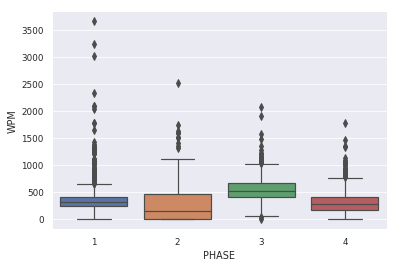

In [159]:
ax = sns.boxplot(x="PHASE", y="WPM", data=df_WPMP_SP.reset_index().rename(columns={"SPDUR": "WPM"}))

if save_images:
    plt.savefig(image_path + os.sep + "wpm_per_phase.svg", format="svg")

In [160]:
WPMP_file = os.path.join(tempdir, 'wpmp_file.csv')
df_WPMP_SP.to_csv(WPMP_file)

In [161]:
%%R -i WPMP_file
if(!require(lme4)){
    install.packages("lme4")
    library(lme4)
}

rdf_WPMP = read.table(WPMP_file, sep=",")
names(rdf_WPMP) = c("TEXT_TYPE", "TEXT_NO", "SUBJ", "PHASE","WPM")
rdf_WPMP$TEXT_NO = factor(rdf_WPMP$TEXT_NO)
rdf_WPMP$SUBJ = factor(rdf_WPMP$SUBJ)
rdf_WPMP$PHASE = factor(rdf_WPMP$PHASE)

mod_wpmp = lmer(WPM ~ TEXT_TYPE + PHASE + (1|SUBJ), data=rdf_WPMP)
mod_wpmp_mle = lmer(WPM ~ TEXT_TYPE + PHASE + (1|SUBJ), data=rdf_WPMP, REML=FALSE) # MLE
mod_wpmp_null_mle = lmer(WPM ~ TEXT_TYPE + (1|SUBJ), data=rdf_WPMP, REML=FALSE) # NULL model

print(summary(mod_wpmp))
print("------------")
print(anova(mod_wpmp_mle, mod_wpmp_null_mle, test="Chisq"))



Linear mixed model fit by REML ['lmerMod']
Formula: WPM ~ TEXT_TYPE + PHASE + (1 | SUBJ)
   Data: rdf_WPMP

REML criterion at convergence: 48900.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.2431 -0.5000 -0.1237  0.2991 13.0795 

Random effects:
 Groups   Name        Variance Std.Dev.
 SUBJ     (Intercept)  9185     95.84  
 Residual             54998    234.52  
Number of obs: 3555, groups:  SUBJ, 15

Fixed effects:
            Estimate Std. Error t value
(Intercept)  362.244     26.112  13.873
TEXT_TYPEMR   -1.302      9.573  -0.136
TEXT_TYPEUR   71.579      9.824   7.286
PHASE2       -73.274     13.178  -5.560
PHASE3       111.173     11.407   9.746
PHASE4       -83.018     10.973  -7.565

Correlation of Fixed Effects:
            (Intr) TEXT_TYPEM TEXT_TYPEU PHASE2 PHASE3
TEXT_TYPEMR -0.187                                    
TEXT_TYPEUR -0.180  0.502                             
PHASE2      -0.097 -0.016     -0.009                  
PHASE3      -0.148  0.023   

In [162]:
%%R -o mod_wpmp_BICLM -o mod_wpmp_BICLM_f

cat("BIC value (mixed model):")
mod_wpmp_BICLM = BICLM(mod_wpmp)
print(mod_wpmp_BICLM)
cat("BIC value (linear model):")
mod_wpmp_BICLM_f = BIC(lm(WPM ~ TEXT_TYPE, data=rdf_WPMP))
print(mod_wpmp_BICLM_f)

BIC value (mixed model):[1] 48962.69
BIC value (linear model):[1] 49837.36


In [163]:
%%R 

confint(mod_wpmp, method="profile", level=0.995, oldNames = FALSE)

                        0.25 %   99.75 %
sd_(Intercept)|SUBJ   58.26211 173.34036
sigma                226.74550 242.39256
(Intercept)          282.40968 442.56842
TEXT_TYPEMR          -28.16262  25.57242
TEXT_TYPEUR           43.99059  99.13580
PHASE2              -110.29629 -36.31785
PHASE3                79.22734 143.47409
PHASE4              -113.75598 -52.11865


In [164]:
%%R 

confint(mod_wpmp_mle, method="profile", level=0.995, oldNames = FALSE)

                        0.25 %   99.75 %
sd_(Intercept)|SUBJ   58.26211 173.34036
sigma                226.74550 242.39256
(Intercept)          282.40968 442.56842
TEXT_TYPEMR          -28.16262  25.57242
TEXT_TYPEUR           43.99059  99.13580
PHASE2              -110.29629 -36.31785
PHASE3                79.22734 143.47409
PHASE4              -113.75598 -52.11865


In [165]:
%%markdown


```The effects of text type and phase on reading speeds WPM are considered, computing WPM at scanpath scale.  
Test of individual effect (minimize BIC): strong individual effect  
BIC value (LMM mod_wpmp): {mod_wpmp_BICLM}
BIC value (linear model): {mod_wpmp_BICLM_f}
ANOVA in mixed model (effect of text type): 2.2e-16 (UR > (MR, HR)) 
```



```The effects of text type and phase on reading speeds WPM are considered, computing WPM at scanpath scale.  
Test of individual effect (minimize BIC): strong individual effect  
BIC value (LMM mod_wpmp): [ 48962.69]
BIC value (linear model): [ 49837.36]
ANOVA in mixed model (effect of text type): 2.2e-16 (UR > (MR, HR)) 
```

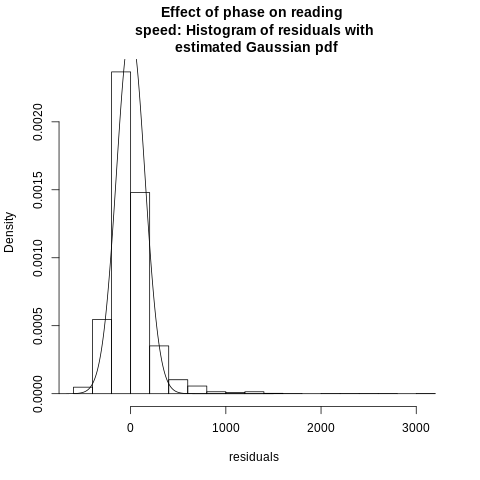

In [166]:
%%R -i save_images -i image_path


if (save_images) {
    svg(paste(image_path,"/wpmp_lmm_residuals.svg", sep=""))
    hist(residuals(mod_wpmp), main="Effect of phase on reading \n speed: Histogram of residuals with \n estimated Gaussian pdf", prob=TRUE, xlab="residuals")
    lines(seq(-1500,1500,length.out=500), dnorm(seq(-1500,1500,length.out=500), mean=mean(residuals(mod_wpm)),sd=sd(residuals(mod_wpm))))
    dev.off()
}

hist(residuals(mod_wpmp), main="Effect of phase on reading \n speed: Histogram of residuals with \n estimated Gaussian pdf", prob=TRUE, xlab="residuals")
lines(seq(-1500,1500,length.out=500), dnorm(seq(-1500,1500,length.out=500), mean=mean(residuals(mod_wpm)),sd=sd(residuals(mod_wpm))))


In [167]:
%%R 

print(shapiro.test(residuals(mod_wpmp)))
print(paste("Sample size:", length(residuals(mod_wpmp))))
print(summary(residuals(mod_wpmp)))


	Shapiro-Wilk normality test

data:  residuals(mod_wpmp)
W = 0.7951, p-value < 2.2e-16

[1] "Sample size: 3555"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-526.04 -117.26  -29.00    0.00   70.15 3067.36 


In [168]:
os.remove(WPMP_file)

## Distances from transitions to max cos inst words (per incoming phase)

In [169]:
# Maximal number of fixations per trial
max_fst = max(df_FST)
print(max_fst)

59


In [170]:
try:
    from pyene_analysis.ema_utils import transition_target
except ImportError:
    import numpy as np
    import pandas as pd

def transition_target(rdf, max_fst, nb_text_type_2):
    """
    Compute distances between transitions and closest target word

    :Parameters:
        `rdf` - data frame with restored states and phases
        `max_fst` - maximal number of fixations per trial
        `nb_text_type_2` - number of types of texts (type 2)

    :Returns:
        `rdfD` - texts of each type
        `transition_target_distance_D` - distance table 
            (distance, incoming phase)
        `freq_transition_target_distance_D` - frequencies of 
            distance for each phase (normalised by all possible 
            distances for a given incoming phase)
        `TD_df` - Dataframe of binary counts: subject, text_type2, 
            incoming phase, distance
        `st_df` - Number of fixations per subject and text number
        `dist_fix_max_cos` - Distance of fixations to closest 
            trigger words
    """
    # texts of each type
    rdfD = {} 
    # distance table (distance, incoming phase)
    transition_target_distance_D = {} 
    # frequencies of distance for each phase 
    # (normalised by all possible distances for a given incoming phase)
    freq_transition_target_distance_D = {} 
     # List of binary counts: subject, text_type2, incoming phase, distance
    TD = []
    nb_phases = len(set(rdf.PHASE))
    # Note that criteria and distances differ for 3 types of text
    # HR and HR+ texts
    # HR/HR+: target words are those with highest cosinst wrt target
    # and must have cosinst > 0.3 (ignored otherwise, some scan paths
    # may have no such trigger words)
    # UR: target words are those with lowest cosinst wrt target;
    # no threshold on cosinst
    # MR: target words are those with highest and lowest cosinst wrt target;
    # no threshold on cosinst
    for tt in ['HR', 'HR+']:
        rdfD[tt] = rdf.loc[rdf.TEXT_TYPE_2 == tt]
        rdfD[tt] = rdfD[tt].reset_index()
        transition_target_distance_D[tt] = np.zeros((max_fst, nb_phases))
        scanpath_transition = []
        scanpath_id = 0
        for i in rdfD[tt].index:
            if rdfD[tt].at[i, 'ISFIRST']:
                j = i
                cos_inst_max_1 = 0
                cos_inst_max_2 = 0
                jwmax_1 = np.infty
                jwmax_2 = np.infty
                while not rdfD[tt].at[j, 'ISLAST']:
                    if rdfD[tt].at[j, 'COS_INST'] > cos_inst_max_1:
                        cos_inst_max_2 = cos_inst_max_1
                        jwmax_2 = jwmax_1
                        cos_inst_max_1 = rdfD[tt].at[j, 'COS_INST']
                        jwmax_1 = j
                    elif rdfD[tt].at[j, 'COS_INST'] > cos_inst_max_2:
                        cos_inst_max_2 = rdfD[tt].at[j, 'COS_INST']
                        jwmax_2 = j
                    j += 1
            elif rdfD[tt].at[i, 'PHASE']-1 != previous_state:
                if cos_inst_max_1 > 0.3:
                    if cos_inst_max_2 > 0.3:
                        dist = min(abs(jwmax_1 - i), abs(jwmax_2 - i))
                    else:
                        dist = abs(jwmax_1 - i)
                    transition_target_distance_D[tt][dist, rdfD[tt].at[i, 'PHASE']-1] += 1
                    TD.append([rdfD[tt].at[i, 'SUBJ'], tt, rdfD[tt].at[i, 'PHASE']-1, dist])
            previous_state = rdfD[tt].at[i, 'PHASE']-1
        freq_transition_target_distance_D[tt] = transition_target_distance_D[tt] / transition_target_distance_D[tt].sum(axis=0)          
    # UR texts￼
    tt = 'UR'
    rdfD['UR'] = rdf.loc[rdf.TEXT_TYPE == 'UR']
    rdfD['UR'] = rdfD['UR'].reset_index()
    transition_target_distance_D['UR'] = np.zeros((max_fst, nb_phases))
    scanpath_transition = []
    scanpath_id = 0
    for i in rdfD['UR'].index:
        if rdfD['UR'].at[i, 'ISFIRST']:
            j = i
            cos_inst_min_1 = 1
            cos_inst_min_2 = 1
            jwmin_1 = np.infty
            jwmin_2 = np.infty
            while not rdfD['UR'].at[j, 'ISLAST']:
                if rdfD['UR'].at[j, 'COS_INST'] < cos_inst_min_1:
                    cos_inst_min_2 = cos_inst_min_1
                    jwmin_2 = jwmin_1
                    cos_inst_min_1 = rdfD['UR'].at[j, 'COS_INST']
                    jwmin_1 = j
                elif rdfD['UR'].at[j, 'COS_INST'] < cos_inst_min_2:
                    cos_inst_min_2 = rdfD['UR'].at[j, 'COS_INST']
                    jwmin_2 = j
                j += 1
        elif rdfD['UR'].at[i, 'PHASE']-1 != previous_state:
            if jwmin_1 != np.infty:
                dist = min(abs(jwmin_1 - i), abs(jwmin_2 - i))
                transition_target_distance_D['UR'][dist, rdfD['UR'].at[i, 'PHASE']-1] += 1
                TD.append([rdfD[tt].at[i, 'SUBJ'], tt, rdfD[tt].at[i, 'PHASE']-1, dist])
        previous_state = rdfD['UR'].at[i, 'PHASE']-1
    freq_transition_target_distance_D['UR'] = transition_target_distance_D['UR'] / transition_target_distance_D['UR'].sum(axis=0)    
    # M texts   ￼
    tt = 'MR'
    rdfD['MR'] = rdf.loc[rdf.TEXT_TYPE_2 == 'MR']
    rdfD['MR'] = rdfD['MR'].reset_index()
    transition_target_distance_D['MR'] = np.zeros((max_fst, nb_phases))
    scanpath_transition = []
    scanpath_id = 0
    for i in rdfD['MR'].index:
        if rdfD['MR'].at[i, 'ISFIRST']:
            j = i
            cos_inst_min = 1
            cos_inst_max = 0 # Error: 1?
            jwmin = np.infty
            jwmax = np.infty
            while not rdfD['MR'].at[j, 'ISLAST']:
                if rdfD['MR'].at[j, 'COS_INST'] < cos_inst_min:
                    cos_inst_min = rdfD['MR'].at[j, 'COS_INST']
                    jwmin = j
                if rdfD['MR'].at[j, 'COS_INST'] > cos_inst_max:
                    cos_inst_max = rdfD['MR'].at[j, 'COS_INST']
                    jwmax = j
                j += 1
        elif rdfD['MR'].at[i, 'PHASE']-1 != previous_state:
            dist = min(abs(jwmin - i), abs(jwmax - i))
            if dist != np.infty:
                transition_target_distance_D['MR'][dist, rdfD['MR'].at[i, 'PHASE']-1] += 1
                TD.append([rdfD[tt].at[i, 'SUBJ'], tt, rdfD[tt].at[i, 'PHASE']-1, dist])
        previous_state = rdfD['MR'].at[i, 'PHASE']-1
    freq_transition_target_distance_D['MR'] = transition_target_distance_D['MR'] / transition_target_distance_D['MR'].sum(axis=0)
    # Make a data frame from TD
    TD_df = pd.DataFrame(data=TD, columns = ['SUBJ', 'TEXT_TYPE_2', 'PHASE', 'dist'])
    # Number of fixations per subject and text number
    st_df = pd.crosstab(rdf['TEXT_NO'],  rdf['SUBJ'], margins = False) 
    # Compute the number of scanpaths for each text type
    # In lines PHASE distance varies first, then PHASE, then TEXT_TYPE_2
    # Number of lines:     
    nbl_dist_fix_max_cos = max_fst * nb_phases * nb_text_type_2
    dist_fix_max_cos = pd.DataFrame(index=range(0, nbl_dist_fix_max_cos), 
                                    columns=['Text', 'ToPhase', 'Dist', 'Freq'])
    i = 0 # Text_type_2
    for tt in transition_target_distance_D.keys():       
        dist_fix_max_cos.loc[(i*max_fst * nb_phases):((i+1)*max_fst * nb_phases)-1, 'Text'] = tt
        # Incoming states for each type of text
        for s in range(nb_phases):
            dist_fix_max_cos.loc[(i*max_fst * nb_phases + s*max_fst):(i*max_fst * nb_phases + (s+1)*max_fst-1), 
                                'ToPhase'] = s
            dist_fix_max_cos.loc[(i*max_fst * nb_phases + s*max_fst):(i*max_fst * nb_phases + (s+1)*max_fst-1), 
                                'Freq'] = \
                freq_transition_target_distance_D[tt][:, s]
        i += 1
    dist_fix_max_cos['Dist'] = range(0,max_fst)* (nb_phases * nb_text_type_2)
    return (rdfD, transition_target_distance_D, freq_transition_target_distance_D, \
        TD_df, st_df, dist_fix_max_cos)


rdfD, transition_target_distance_D, freq_transition_target_distance_D, \
    TD_df, st_df, dist_fix_max_cos = transition_target(rdf, max_fst, nb_text_type_2)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in divide


In [171]:
for t in en_tt:
    print('Number of phase transitions in text ' + t + ': ' + str(transition_target_distance_D[t].sum()))

Number of phase transitions in text UR: 423.0
Number of phase transitions in text HR: 194.0
Number of phase transitions in text HR+: 200.0
Number of phase transitions in text MR: 614.0


In [172]:
st_df.tail(10)
# rdf[np.logical_and(rdf.TEXT_NO==59, rdf.SUBJ==2)]         

SUBJ     1   2   3   4   5   6   7   8   9   10  11  12  13  14  15
TEXT_NO                                                            
51       50  45  62  58  27  27  58  47  48  38  32  44  27  11  50
52       54  14  84  68  35  40  54  36  40  33  40  24  24  32  53
53       46  11  40  47  71  37  74  29  37  35  45  30  24   2  28
54       63  10  53  54  57  35  31  41  41  44  26  42  32  17  36
55       70   0  48  66  52  10  33  40  61  36  59  34  30  45  43
56       54   0  25  57  32  29  16  29  60   6  29  31  31   3  38
57       52   0  19  17  20  22  21  29  71  20  25  24  87  29  30
58       48   0   0  28  13   7   0  26  79  16  56  17  25   5  11
59       19   0   0   0  18  11   0   0  21  25  23   0  38   0  18
60        0   0   0   0   0   0   0   0   0   0   0   0   0   0  10

In [173]:
print(transition_target_distance_D['HR'].sum() / rdf[['TEXT_TYPE_2', 'ISFIRST']].groupby('TEXT_TYPE_2').sum().loc['HR'])
print(transition_target_distance_D['HR+'].sum() / rdf[['TEXT_TYPE_2', 'ISFIRST']].groupby('TEXT_TYPE_2').sum().loc['HR+'])
print(transition_target_distance_D['UR'].sum() / rdf[['TEXT_TYPE_2', 'ISFIRST']].groupby('TEXT_TYPE_2').sum().loc['UR'])

ISFIRST    0.437923
Name: HR, dtype: float64
ISFIRST    0.555556
Name: HR+, dtype: float64
ISFIRST    0.527431
Name: UR, dtype: float64


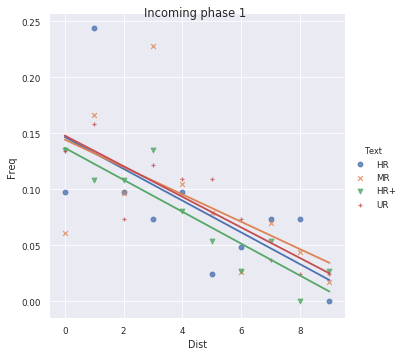

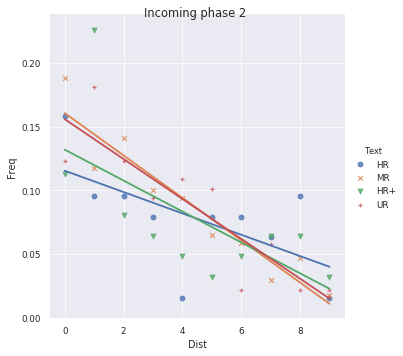

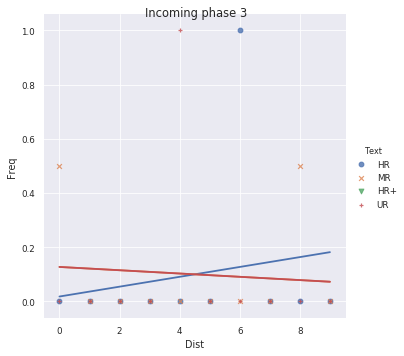

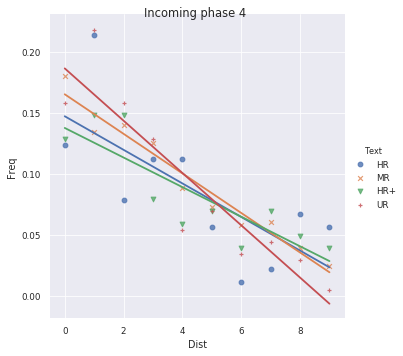

In [174]:
sns.lmplot(x="Dist", y="Freq", hue="Text", ci=None, markers=["o", "x", "v", "+"],
           data=dist_fix_max_cos.loc[(dist_fix_max_cos.ToPhase == 0) & (dist_fix_max_cos.Dist < 10)]).fig.suptitle("Incoming phase 1");

if save_images:
    plt.savefig(image_path + os.sep + "dist_freq_1.svg", format="svg")
    
sns.lmplot(x="Dist", y="Freq", hue="Text", ci=None, markers=["o", "x", "v", "+"],
           data=dist_fix_max_cos.loc[(dist_fix_max_cos.ToPhase == 1) & (dist_fix_max_cos.Dist < 10)]).fig.suptitle("Incoming phase 2");

if save_images:
    plt.savefig(image_path + os.sep + "dist_freq_2.svg", format="svg")

sns.lmplot(x="Dist", y="Freq", hue="Text", ci=None, markers=["o", "x", "v", "+"],
           data=dist_fix_max_cos.loc[(dist_fix_max_cos.ToPhase == 2) & (dist_fix_max_cos.Dist < 10)]).fig.suptitle("Incoming phase 3");

if save_images:
    plt.savefig(image_path + os.sep + "dist_freq_3.svg", format="svg")

sns.lmplot(x="Dist", y="Freq", hue="Text", ci=None, markers=["o", "x", "v", "+"],
           data=dist_fix_max_cos.loc[(dist_fix_max_cos.ToPhase == 3) & (dist_fix_max_cos.Dist < 10)]).fig.suptitle("Incoming phase 4");

if save_images:
    plt.savefig(image_path + os.sep + "dist_freq_4.svg", format="svg")


In [175]:
for tt in transition_target_distance_D.keys():
    TTD_file = os.path.join(tempdir, 'ttd_file_'+tt+'.csv')
    np.savetxt(TTD_file, transition_target_distance_D[tt], delimiter=",")

TD_file = os.path.join(tempdir, 'td_file_.csv')
TD_df.to_csv(TD_file)

### Model transition probabilities with binary GLMMs

Remove phase 2 since incoming transitions are rare

In [176]:
# Path to R scripts
R_PATH = DATA_PATH.split(os.sep)
R_PATH[0] = '/'
R_PATH = R_PATH[0:-2] + ["R-scripts"]
CA_file = os.path.join(*(R_PATH + ["ca.R"]))
R_PATH = os.path.join(*R_PATH)
R_PATH = str(R_PATH)
CA_file = str(CA_file)

In [177]:
R_PATH = os.getcwd()
R_PATH = os.path.join(R_PATH, "..", "..", "PyENE-analysis", "pyene_analysis", "src","R-scripts")
os.listdir(R_PATH)

['ca.R', 'ema_utils.R', 'a_posteriori_analysis_ggplots.R']

In [178]:
REU_file = os.path.join(R_PATH, "ema_utils.R")

In [179]:
%%R -i TD_file -i REU_file -i R_PATH

print(list.files(R_PATH))
print(REU_file)


[1] "a_posteriori_analysis_ggplots.R" "ca.R"                           
[3] "ema_utils.R"                    
[1] "/mnt/devlp/PyENE-analysis/notebooks/../../PyENE-analysis/pyene_analysis/src/R-scripts/ema_utils.R"


In [180]:
%%R -i TD_file -i REU_file -i R_PATH

if ("ema_utils.R" %in% list.files(R_PATH)) {
    source(REU_file) } else {

        dist.table = function(TD_file, phase_exclude)
        {
            # Compute counts of transitions with specified distance
            # excluding phase_exclude if data frame contained in file 
            # TD_file

            # Concatenate tables, adding text type
            TD_df = read.table(TD_file, sep=',', header=TRUE, row.names=1)
            TD_df$SUBJ = factor(TD_df$SUBJ)
            TD_df$PHASE = factor(TD_df$PHASE)


            # Remove phase_exclude
            TD_df = TD_df[TD_df$PHASE!=phase_exclude,]
            TD_df$PHASE = factor(TD_df$PHASE)

            # Add total number of transitions for a given subject, type, phase and distance
            TDC_df = cbind(TD_df, rep(1, dim(TD_df)[1]))
            names(TDC_df)[dim(TDC_df)[2]] = "counts"

            library(lme4)

            # Total number of occurrences for given SUBJ, TEXT_TYPE_2, PHASE, dist
            TC = aggregate(TDC_df$counts,
                    list(SUBJ = TDC_df$SUBJ,
                        TEXT_TYPE_2 = TDC_df$TEXT_TYPE_2,
                        PHASE = TDC_df$PHASE,
                        dist = TDC_df$dist),
                    sum)

            # Total number of occurrences for given SUBJ, TEXT_TYPE_2, PHASE
            TCT = aggregate(TDC_df$counts,
                    list(SUBJ = TDC_df$SUBJ,
                        TEXT_TYPE_2 = TDC_df$TEXT_TYPE_2,
                        PHASE = TDC_df$PHASE),
                    sum)

            nbr = dim(TC)[1]
            TC = cbind(TC, rep(1, nbr))
            nbc = dim(TC)[2]

            for (i in 1:nbr) {
                TC[i,nbc] = TCT[TCT$SUBJ==TC$SUBJ[i] & TCT$TEXT_TYPE_2==TC$TEXT_TYPE_2[i] & TCT$PHASE==TC$PHASE[i], dim(TCT)[2]]
            }
            names(TC)[5:6] = c("counts", "total")

            TC$y = cbind(TC$counts, TC$total-TC$counts)

            return(TC)
        }}

TC = dist.table(TD_file, 2)

In [181]:
%%R -o modtc_all_ran_BICLM

# Estimation: random subject effect, fixed distance, phase and text_type effects
modtc.all.ran = glmer(y ~ dist * TEXT_TYPE_2 * PHASE + (1|SUBJ), family="binomial", data=TC)
print(summary(modtc.all.ran))
modtc_all_ran_BICLM = BICLM(modtc.all.ran)
print(paste("BIC (GLMM):", modtc_all_ran_BICLM))


/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Correlation matrix not shown by default, as p = 24 > 12.
Use print(summary(modtc.all.ran), correlation=TRUE)  or
    vcov(summary(modtc.all.ran))        if you need it


  warnings.warn(x, RRuntimeWarning)


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: y ~ dist * TEXT_TYPE_2 * PHASE + (1 | SUBJ)
   Data: TC

     AIC      BIC   logLik deviance df.resid 
  2336.4   2455.0  -1143.2   2286.4      824 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.7341 -0.4350 -0.0157  0.5149  3.8853 

Random effects:
 Groups Name        Variance Std.Dev.
 SUBJ   (Intercept) 0.05895  0.2428  
Number of obs: 849, groups:  SUBJ, 15

Fixed effects:
                             Estimate Std. Error z value Pr(>|z|)  
(Intercept)                -0.6175007  0.2741774  -2.252   0.0243 *
dist                       -0.0232568  0.0363465  -0.640   0.5223  
TEXT_TYPE_2HR+             -0.3514394  0.3887167  -0.904   0.3659  
TEXT_TYPE_2MR              -0.6013798  0.3078901  -1.953   0.0508 .
TEXT_TYPE_2UR              -0.7638236  0.3218131  -2.374   0.0176 *
PHASE1                     -0.5627261  0.3382587  -1.664   0.0

Only models 1 (dist * PHASE + TEXT_TYPE_2 + (1|SUBJ) ) and 2 (dist * TEXT_TYPE_2 + PHASE + (1|SUBJ)) reached convergence. <br>

In [182]:
%%R -o modtc_nott_ran_BICLM -o modtc_nop_ran_BICLM -o modtc_nod_ran_BICLM -o modtc_add_ran_BICLM -o modtc_p_ran_BICLM

library(lme4)

# No  dist * TEXT_TYPE_2
modtc.nott.ran = glmer(y ~ dist * PHASE + TEXT_TYPE_2 + (1|SUBJ), family="binomial", data=TC)
print(summary(modtc.nott.ran))
modtc_nott_ran_BICLM = BICLM(modtc.nott.ran)

print("------------")
# No  dist * PHASE
modtc.nop.ran = glmer(y ~ dist * TEXT_TYPE_2 + PHASE + (1|SUBJ), family="binomial", data=TC)
print(summary(modtc.nop.ran))
modtc_nop_ran_BICLM = BICLM(modtc.nop.ran)
print("------------")

# No  TEXT_TYPE_2 * PHASE
modtc.nod.ran = glmer(y ~ dist + TEXT_TYPE_2 * PHASE + (1|SUBJ), family="binomial", data=TC)
print(summary(modtc.nod.ran))
modtc_nod_ran_BICLM = BICLM(modtc.nod.ran)

print("------------")
# No  * 
modtc.add.ran = glmer(y ~ dist + TEXT_TYPE_2 + PHASE + (1|SUBJ), family="binomial", data=TC)
print(summary(modtc.add.ran))
modtc_add_ran_BICLM = BICLM(modtc.add.ran)

print("------------")
# Pairwise interactions
modtc.p.ran = glmer(y ~ dist * TEXT_TYPE_2 + dist * PHASE + (1|SUBJ), family="binomial", data=TC)
print(summary(modtc.p.ran))
modtc_p_ran_BICLM = BICLM(modtc.p.ran)


/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Correlation matrix not shown by default, as p = 13 > 12.
Use print(summary(modtc.nod.ran), correlation=TRUE)  or
    vcov(summary(modtc.nod.ran))        if you need it


  warnings.warn(x, RRuntimeWarning)


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: y ~ dist * PHASE + TEXT_TYPE_2 + (1 | SUBJ)
   Data: TC

     AIC      BIC   logLik deviance df.resid 
  2323.6   2371.1  -1151.8   2303.6      839 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6675 -0.4412 -0.0057  0.5111  4.0117 

Random effects:
 Groups Name        Variance Std.Dev.
 SUBJ   (Intercept) 0.05941  0.2437  
Number of obs: 849, groups:  SUBJ, 15

Fixed effects:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -0.76071    0.14348  -5.302 1.15e-07 ***
dist           -0.03698    0.01466  -2.523  0.01164 *  
PHASE1         -0.25994    0.12491  -2.081  0.03742 *  
PHASE3         -0.30255    0.12220  -2.476  0.01329 *  
TEXT_TYPE_2HR+ -0.04216    0.11351  -0.371  0.71033    
TEXT_TYPE_2MR  -0.62925    0.09286  -6.777 1.23e-11 ***
TEXT_TYPE_2UR  -0.41585    0.09736  -4.271 1.94e-05 ***
dist:PHASE1    -0.0145

In [183]:
%%R 

print(attr(modtc.add.ran,"optinfo")$conv)
print(paste("BIC (GLMM) for modtc.nott.ran", modtc_nott_ran_BICLM))
print(paste("BIC (GLMM) for modtc.nod.ran", modtc_nod_ran_BICLM))
print(paste("BIC (GLMM) for modtc.nop.ran", modtc_nop_ran_BICLM))
print(paste("BIC (GLMM) for modtc.add.ran", modtc_add_ran_BICLM))
print(attr(modtc.p.ran,"optinfo")$conv)
print(paste("BIC (GLMM) for modtc.p.ran", modtc_p_ran_BICLM))
print(paste("Recall 3-wise interactions BIC (GLMM):", modtc_all_ran_BICLM))

$opt
[1] 0

$lme4
list()

[1] "BIC (GLMM) for modtc.nott.ran 2322.55228383642"
[1] "BIC (GLMM) for modtc.nod.ran 2328.61533697234"
[1] "BIC (GLMM) for modtc.nop.ran 2322.56689655786"
[1] "BIC (GLMM) for modtc.add.ran 2334.24438044774"
$opt
[1] 0

$lme4
$lme4$code
[1] -1

$lme4$messages
[1] "Model failed to converge with max|grad| = 0.0102467 (tol = 0.001, component 1)"


[1] "BIC (GLMM) for modtc.p.ran 2311.63465471261"
[1] "Recall 3-wise interactions BIC (GLMM): 2305.31608685022"


3-wise interactions between dist, PHASE, TEXT_TYPE_2 poorly significant but remember lack of convergence   
pairwise interactions seem significant but remember lack of convergence   
reference model dist * TEXT_TYPE_2 + PHASE + (1|SUBJ): modtc.nop.ran  

In [184]:
%%R -o modtc_nod_ran_BICLM -o modtc_nopp_ran_BICLM -o modtc_nott2_ran_BICLM

# No  dist 
modtc.nod.ran = glmer(y ~ PHASE + TEXT_TYPE_2 + (1|SUBJ), family="binomial", data=TC)
print(summary(modtc.nod.ran))
modtc_nod_ran_BICLM = BICLM(modtc.nod.ran)

print("------------")
# No  PHASE
modtc.nopp.ran = glmer(y ~ dist * TEXT_TYPE_2 + (1|SUBJ), family="binomial", data=TC)
print(summary(modtc.nopp.ran))
modtc_nopp_ran_BICLM = BICLM(modtc.nopp.ran)

print("------------")
# No  TEXT_TYPE_2 
modtc.nott2.ran = glmer(y ~ dist + PHASE + (1|SUBJ), family="binomial", data=TC)
print(summary(modtc.nott2.ran))
modtc_nott2_ran_BICLM = BICLM(modtc.nott2.ran)



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: y ~ PHASE + TEXT_TYPE_2 + (1 | SUBJ)
   Data: TC

     AIC      BIC   logLik deviance df.resid 
  2441.0   2474.2  -1213.5   2427.0      842 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6645 -0.5155 -0.0547  0.5143  4.6810 

Random effects:
 Groups Name        Variance Std.Dev.
 SUBJ   (Intercept) 0.09921  0.315   
Number of obs: 849, groups:  SUBJ, 15

Fixed effects:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -0.91287    0.13316  -6.855 7.12e-12 ***
PHASE1         -0.37343    0.08532  -4.377 1.21e-05 ***
PHASE3         -0.56661    0.08786  -6.449 1.13e-10 ***
TEXT_TYPE_2HR+ -0.05953    0.11288  -0.527    0.598    
TEXT_TYPE_2MR  -0.62041    0.09246  -6.710 1.94e-11 ***
TEXT_TYPE_2UR  -0.41833    0.09675  -4.324 1.53e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fi

dist, PHASE, TEXT_TYPE_2: all significant  

In [185]:
%%R 
print(attr(modtc.nod.ran,"optinfo")$conv)
print(paste("BIC (GLMM) for modtc.nod.ran", modtc_nod_ran_BICLM))
print(attr(modtc.nopp.ran,"optinfo")$conv)
print(paste("BIC (GLMM) for modtc.nopp.ran", modtc_nopp_ran_BICLM))
print(attr(modtc.nott2.ran,"optinfo")$conv)
print(paste("BIC (GLMM) for modtc.nott2.ran", modtc_nott2_ran_BICLM))

print(paste("Recall BIC (GLMM) for modtc.nop.ran", modtc_nop_ran_BICLM))

$opt
[1] 0

$lme4
list()

[1] "BIC (GLMM) for modtc.nod.ran 2445.92490352913"
$opt
[1] 0

$lme4
$lme4$code
[1] -1

$lme4$messages
[1] "Model failed to converge with max|grad| = 0.00188423 (tol = 0.001, component 1)"


[1] "BIC (GLMM) for modtc.nopp.ran 2360.93042812908"
$opt
[1] 0

$lme4
list()

[1] "BIC (GLMM) for modtc.nott2.ran 2403.96297347495"
[1] "Recall BIC (GLMM) for modtc.nop.ran 2322.56689655786"


In [186]:
%%R -o BICLM_null_diff_bin -o modtc_null_ran_BICLM

modtc_null_ran_BICLM = modtc_nod_ran_BICLM
BICLM_null_diff_bin = modtc_nop_ran_BICLM - modtc_null_ran_BICLM
print(paste("BIC (LMM) diff with NULL model", BICLM_null_diff_bin))

[1] "BIC (LMM) diff with NULL model -123.358006971267"


In [187]:
%%R -o modtc_add_f_BICML

library(lme4)

# No SUBJ
modtc.add.f = glm(y ~ dist * TEXT_TYPE_2 + PHASE, family="binomial", data=TC)
print(summary(modtc.add.f))
modtc_add_f_BICML = BIC(modtc.add.f)

print(paste("BIC for modtc.add.f", modtc_add_f_BICML))



Call:
glm(formula = y ~ dist * TEXT_TYPE_2 + PHASE, family = "binomial", 
    data = TC)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.24657  -0.47342   0.03169   0.58872   2.75401  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -0.8952248  0.1330416  -6.729 1.71e-11 ***
dist                -0.0425214  0.0162240  -2.621 0.008770 ** 
TEXT_TYPE_2HR+      -0.0513059  0.1649864  -0.311 0.755823    
TEXT_TYPE_2MR       -0.3301813  0.1346549  -2.452 0.014204 *  
TEXT_TYPE_2UR       -0.2536380  0.1393878  -1.820 0.068811 .  
PHASE1              -0.3008109  0.0853728  -3.523 0.000426 ***
PHASE3              -0.4980564  0.0785311  -6.342 2.27e-10 ***
dist:TEXT_TYPE_2HR+ -0.0002683  0.0222473  -0.012 0.990379    
dist:TEXT_TYPE_2MR  -0.0569338  0.0198400  -2.870 0.004109 ** 
dist:TEXT_TYPE_2UR  -0.0332295  0.0197173  -1.685 0.091931 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersio

Significance of SUBJ effect (significant here)

Confidence interval of random effect

In [188]:
%%R -o modtc_nop_ran_confint

modtc_nop_ran_confint = confint(modtc.nop.ran, method="profile", level=0.995, oldNames = FALSE)
modtc_nop_ran_confint

                         0.25 %       99.75 %
sd_(Intercept)|SUBJ  0.12237851  0.5015771746
(Intercept)         -1.19831134 -0.3496905979
dist                -0.08234106  0.0091618154
TEXT_TYPE_2HR+      -0.50403260  0.4264041858
TEXT_TYPE_2MR       -0.74604010  0.0167316459
TEXT_TYPE_2UR       -0.63808889  0.1527047600
PHASE1              -0.56889092 -0.0863004210
PHASE3              -0.79348039 -0.3023817268
dist:TEXT_TYPE_2HR+ -0.06516582  0.0601200795
dist:TEXT_TYPE_2MR  -0.11071143  0.0009870679
dist:TEXT_TYPE_2UR  -0.08922521  0.0219522701


In [189]:
%%markdown


```The effects of distance, type of text2 and incoming phase are considered on the occurrence of transitions through binomial GLMMs. The order-3-interactions model does not converge.   
AIC defined as -2 * (maximal loglikelihood + nb free params); to be minimized (sim. for BIC).   
Only two models with pairwise interactions converge:  
dist * PHASE + TEXT_TYPE_2 + (1|SUBJ) (BIC modtc_nod_ran {modtc_nod_ran_BICLM})  
and   
dist * TEXT_TYPE_2 + PHASE + (1|SUBJ) (BIC modtc_nop_ran {modtc_nop_ran_BICLM}) (significant effect of interactions dist * TEXT_TYPE_2). ***Best model***.
Comparison with a model without interaction: dist + TEXT_TYPE_2 + PHASE + (1|SUBJ) (BIC modtc_add_ran {modtc_add_ran_BICLM})  
Comparison with models without dist (BIC modtc_nod_ran {modtc_nod_ran_BICLM}), phase (modtc_nopp_ran {modtc_nopp_ran_BICLM}), and text2 (modtc_nott2_ran {modtc_nott2_ran_BICLM}) effects: each effect is strongly significant.  
Comparison with a fixed effect (GLM) model with dist * TEXT_TYPE_2 interactions, no random indivual effect: dist * TEXT_TYPE_2 + PHASE (BIC modtc_add_f {modtc_add_f_BICML}): strong individual effect. Confidence intervals for random effect variance in the corresponding mixed model: {modtc_nop_ran_confint[0]}
```



```The effects of distance, type of text2 and incoming phase are considered on the occurrence of transitions through binomial GLMMs. The order-3-interactions model does not converge.   
AIC defined as -2 * (maximal loglikelihood + nb free params); to be minimized (sim. for BIC).   
Only two models with pairwise interactions converge:  
dist * PHASE + TEXT_TYPE_2 + (1|SUBJ) (BIC modtc_nod_ran [ 2445.92])  
and   
dist * TEXT_TYPE_2 + PHASE + (1|SUBJ) (BIC modtc_nop_ran [ 2322.57]) (significant effect of interactions dist * TEXT_TYPE_2). ***Best model***.
Comparison with a model without interaction: dist + TEXT_TYPE_2 + PHASE + (1|SUBJ) (BIC modtc_add_ran [ 2334.24])  
Comparison with models without dist (BIC modtc_nod_ran [ 2445.92]), phase (modtc_nopp_ran [ 2360.93]), and text2 (modtc_nott2_ran [ 2403.96]) effects: each effect is strongly significant.  
Comparison with a fixed effect (GLM) model with dist * TEXT_TYPE_2 interactions, no random indivual effect: dist * TEXT_TYPE_2 + PHASE (BIC modtc_add_f [ 2405.68]): strong individual effect. Confidence intervals for random effect variance in the corresponding mixed model: [ 0.12  0.5 ]
```

### Work directly on frequencies

3-wise interactions are significant

In [190]:
%%R -o modtclin_all_ran_BICLM

TC$freq = TC$counts / TC$total

# Estimation: random subject effect, fixed distance, phase and text_type effects
modtclin.all.ran = lmer(freq ~ dist * TEXT_TYPE_2 * PHASE + (1|SUBJ), data=TC)
print(summary(modtclin.all.ran))
modtclin_all_ran_BICLM = BICLM(modtclin.all.ran)

print(paste("BIC (LMM) for modtclin.all.ran:", modtclin_all_ran_BICLM))

/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Correlation matrix not shown by default, as p = 24 > 12.
Use print(summary(modtclin.all.ran), correlation=TRUE)  or
    vcov(summary(modtclin.all.ran))        if you need it


  warnings.warn(x, RRuntimeWarning)


Linear mixed model fit by REML ['lmerMod']
Formula: freq ~ dist * TEXT_TYPE_2 * PHASE + (1 | SUBJ)
   Data: TC

REML criterion at convergence: -692

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4912 -0.5863 -0.1652  0.2803  5.8547 

Random effects:
 Groups   Name        Variance Std.Dev.
 SUBJ     (Intercept) 0.004652 0.0682  
 Residual             0.020434 0.1429  
Number of obs: 849, groups:  SUBJ, 15

Fixed effects:
                             Estimate Std. Error t value
(Intercept)                 3.779e-01  3.873e-02   9.756
dist                       -9.160e-04  4.830e-03  -0.190
TEXT_TYPE_2HR+              4.705e-02  4.991e-02   0.943
TEXT_TYPE_2MR              -8.537e-02  4.298e-02  -1.986
TEXT_TYPE_2UR              -1.340e-01  4.218e-02  -3.176
PHASE1                     -6.365e-02  4.516e-02  -1.409
PHASE3                     -1.483e-01  4.434e-02  -3.345
dist:TEXT_TYPE_2HR+        -9.914e-03  6.718e-03  -1.476
dist:TEXT_TYPE_2MR         -7.411e-03  5.962e-

In [191]:
%%R -o modtclin_add_ran_BICLM

# No * 
modtclin.add.ran = lmer(freq ~ dist + PHASE + TEXT_TYPE_2 + (1|SUBJ), data=TC)
print(summary(modtclin.add.ran))
modtclin_add_ran_BICLM = BICLM(modtclin.add.ran)

print(paste("BIC (LMM) for modtclin.add.ran:", modtclin_add_ran_BICLM))

Linear mixed model fit by REML ['lmerMod']
Formula: freq ~ dist + PHASE + TEXT_TYPE_2 + (1 | SUBJ)
   Data: TC

REML criterion at convergence: -805.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.3834 -0.5857 -0.1887  0.2598  5.8946 

Random effects:
 Groups   Name        Variance Std.Dev.
 SUBJ     (Intercept) 0.004671 0.06834 
 Residual             0.020521 0.14325 
Number of obs: 849, groups:  SUBJ, 15

Fixed effects:
                 Estimate Std. Error t value
(Intercept)     0.3792022  0.0236583  16.028
dist           -0.0049334  0.0009266  -5.324
PHASE1         -0.0651133  0.0131519  -4.951
PHASE3         -0.1116305  0.0131822  -8.468
TEXT_TYPE_2HR+ -0.0126859  0.0163466  -0.776
TEXT_TYPE_2MR  -0.1091556  0.0144801  -7.538
TEXT_TYPE_2UR  -0.0848813  0.0148999  -5.697

Correlation of Fixed Effects:
             (Intr) dist   PHASE1 PHASE3 TEXT_TYPE_2H TEXT_TYPE_2M
dist         -0.202                                               
PHASE1       -0.322 -0.057      

In [192]:
%%R -o modtclin_dp_ran_BICLM -o modtclin_dtt_ran_BICLM -o modtclin_ptt_ran_BICLM -o modtclin_p_ran_BICLM

# dist * PHASE
modtclin.dp.ran = lmer(freq ~ dist * TEXT_TYPE_2 + PHASE + (1|SUBJ), data=TC)
print(summary(modtclin.dp.ran))
modtclin_dp_ran_BICLM = BICLM(modtclin.dp.ran)

# dist * TEXT_TYPE_2
modtclin.dtt.ran = lmer(freq ~ dist * PHASE + TEXT_TYPE_2 + (1|SUBJ), data=TC)
print(summary(modtclin.dtt.ran))
modtclin_dtt_ran_BICLM = BICLM(modtclin.dtt.ran)

# PHASE * TEXT_TYPE_2
modtclin.ptt.ran = lmer(freq ~ dist + PHASE * TEXT_TYPE_2 + (1|SUBJ), data=TC)
print(summary(modtclin.ptt.ran))
modtclin_ptt_ran_BICLM = BICLM(modtclin.ptt.ran)

# All pairwise interactions
modtclin.p.ran = lmer(freq ~ dist * PHASE + dist * TEXT_TYPE_2 + (1|SUBJ), data=TC)
print(summary(modtclin.p.ran))
modtclin_p_ran_BICLM = BICLM(modtclin.p.ran)


/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Correlation matrix not shown by default, as p = 13 > 12.
Use print(summary(modtclin.ptt.ran), correlation=TRUE)  or
    vcov(summary(modtclin.ptt.ran))        if you need it


  warnings.warn(x, RRuntimeWarning)


Linear mixed model fit by REML ['lmerMod']
Formula: freq ~ dist * TEXT_TYPE_2 + PHASE + (1 | SUBJ)
   Data: TC

REML criterion at convergence: -778.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4627 -0.5894 -0.1811  0.2678  5.8508 

Random effects:
 Groups   Name        Variance Std.Dev.
 SUBJ     (Intercept) 0.004619 0.06797 
 Residual             0.020496 0.14316 
Number of obs: 849, groups:  SUBJ, 15

Fixed effects:
                      Estimate Std. Error t value
(Intercept)          0.3661849  0.0261521  14.002
dist                -0.0025924  0.0022428  -1.156
TEXT_TYPE_2HR+       0.0131334  0.0238199   0.551
TEXT_TYPE_2MR       -0.0857325  0.0214640  -3.994
TEXT_TYPE_2UR       -0.0794683  0.0213792  -3.717
PHASE1              -0.0655885  0.0131495  -4.988
PHASE3              -0.1122226  0.0131783  -8.516
dist:TEXT_TYPE_2HR+ -0.0044880  0.0030190  -1.487
dist:TEXT_TYPE_2MR  -0.0042252  0.0028597  -1.477
dist:TEXT_TYPE_2UR  -0.0009754  0.0026700  -0.365

Correl

In [193]:
%%R 
print(paste("BIC (LMM) for modtclin.all.ran", modtclin_all_ran_BICLM))
print(paste("BIC (LMM) for modtclin.dp.ran", modtclin_dp_ran_BICLM))
print(paste("BIC (LMM) for modtclin.dtt.ran", modtclin_dtt_ran_BICLM ))
print(paste("BIC (LMM) for modtclin.ptt.ran", modtclin_ptt_ran_BICLM ))
print(paste("BIC (LMM) for modtclin.p.ran", modtclin_p_ran_BICLM ))
print(paste("Recalling BIC (LMM) for modtclin.add.ran", modtclin_add_ran_BICLM))

[1] "BIC (LMM) for modtclin.all.ran -860.652351100774"
[1] "BIC (LMM) for modtclin.dp.ran -843.927343537487"
[1] "BIC (LMM) for modtclin.dtt.ran -840.72111209483"
[1] "BIC (LMM) for modtclin.ptt.ran -849.389817849854"
[1] "BIC (LMM) for modtclin.p.ran -845.089994874294"
[1] "Recalling BIC (LMM) for modtclin.add.ran -839.718625206285"


In [194]:
%%R 

# MLE
modtclin.all.ran.lme = lmer(freq ~ TEXT_TYPE_2  * dist * PHASE + (1|SUBJ), data=TC, REML=FALSE)


In [195]:
%%R -o modtclin_notype_ran_BICLM

# No TEXT_TYPE_2
modtclin.notype.ran = lmer(freq ~ dist * PHASE + (1|SUBJ), data=TC)
print(summary(modtclin.notype.ran))

modtclin_notype_ran_BICLM = BICLM(modtclin.notype.ran)

modtclin.notype.ran.mle = lmer(freq ~ dist * PHASE + (1|SUBJ), data=TC, REML=FALSE)

print(anova(modtclin.all.ran.lme, modtclin.notype.ran.mle, test="Chisq"))


Linear mixed model fit by REML ['lmerMod']
Formula: freq ~ dist * PHASE + (1 | SUBJ)
   Data: TC

REML criterion at convergence: -726.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5933 -0.5273 -0.2200  0.2511  6.0903 

Random effects:
 Groups   Name        Variance Std.Dev.
 SUBJ     (Intercept) 0.004535 0.06735 
 Residual             0.022552 0.15017 
Number of obs: 849, groups:  SUBJ, 15

Fixed effects:
             Estimate Std. Error t value
(Intercept)  0.312174   0.023244  13.430
dist        -0.004731   0.001975  -2.395
PHASE1      -0.070717   0.019580  -3.612
PHASE3      -0.103203   0.019551  -5.279
dist:PHASE1  0.001013   0.002437   0.416
dist:PHASE3 -0.001331   0.002567  -0.519

Correlation of Fixed Effects:
            (Intr) dist   PHASE1 PHASE3 d:PHASE1
dist        -0.461                              
PHASE1      -0.504  0.538                       
PHASE3      -0.529  0.550  0.601                
dist:PHASE1  0.376 -0.797 -0.710 -0.450         
dist:PHA

In [196]:
%%R -o modtclin_nophase_ran_BICLM

# No PHASE
modtclin.nophase.ran = lmer(freq ~ dist * TEXT_TYPE_2 + (1|SUBJ), data=TC)
print(summary(modtclin.notype.ran))

modtclin_nophase_ran_BICLM = BICLM(modtclin.nophase.ran)

modtclin.nophase.ran.mle = lmer(freq ~ dist * TEXT_TYPE_2 + (1|SUBJ), data=TC, REML=FALSE)

print(anova(modtclin.all.ran.lme, modtclin.nophase.ran.mle, test="Chisq"))

Linear mixed model fit by REML ['lmerMod']
Formula: freq ~ dist * PHASE + (1 | SUBJ)
   Data: TC

REML criterion at convergence: -726.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5933 -0.5273 -0.2200  0.2511  6.0903 

Random effects:
 Groups   Name        Variance Std.Dev.
 SUBJ     (Intercept) 0.004535 0.06735 
 Residual             0.022552 0.15017 
Number of obs: 849, groups:  SUBJ, 15

Fixed effects:
             Estimate Std. Error t value
(Intercept)  0.312174   0.023244  13.430
dist        -0.004731   0.001975  -2.395
PHASE1      -0.070717   0.019580  -3.612
PHASE3      -0.103203   0.019551  -5.279
dist:PHASE1  0.001013   0.002437   0.416
dist:PHASE3 -0.001331   0.002567  -0.519

Correlation of Fixed Effects:
            (Intr) dist   PHASE1 PHASE3 d:PHASE1
dist        -0.461                              
PHASE1      -0.504  0.538                       
PHASE3      -0.529  0.550  0.601                
dist:PHASE1  0.376 -0.797 -0.710 -0.450         
dist:PHA

In [197]:
%%R -o BICLM_null_diff -o modtclin_null_ran_BICLM

# No dist
modtclin.nodist.ran = lmer(freq ~ PHASE * TEXT_TYPE_2 + (1|SUBJ), data=TC)
print(summary(modtclin.notype.ran))

modtclin.nodist.ran.mle = lmer(freq ~ PHASE * TEXT_TYPE_2 + (1|SUBJ), data=TC, REML=FALSE)

print(anova(modtclin.all.ran.lme, modtclin.nodist.ran.mle, test="Chisq"))

modtclin_null_ran_BICLM = BICLM(modtclin.nodist.ran)
BICLM_null_diff = modtclin_all_ran_BICLM - modtclin_null_ran_BICLM
print(paste("BIC (LMM) diff with NULL model", BICLM_null_diff))

Linear mixed model fit by REML ['lmerMod']
Formula: freq ~ dist * PHASE + (1 | SUBJ)
   Data: TC

REML criterion at convergence: -726.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5933 -0.5273 -0.2200  0.2511  6.0903 

Random effects:
 Groups   Name        Variance Std.Dev.
 SUBJ     (Intercept) 0.004535 0.06735 
 Residual             0.022552 0.15017 
Number of obs: 849, groups:  SUBJ, 15

Fixed effects:
             Estimate Std. Error t value
(Intercept)  0.312174   0.023244  13.430
dist        -0.004731   0.001975  -2.395
PHASE1      -0.070717   0.019580  -3.612
PHASE3      -0.103203   0.019551  -5.279
dist:PHASE1  0.001013   0.002437   0.416
dist:PHASE3 -0.001331   0.002567  -0.519

Correlation of Fixed Effects:
            (Intr) dist   PHASE1 PHASE3 d:PHASE1
dist        -0.461                              
PHASE1      -0.504  0.538                       
PHASE3      -0.529  0.550  0.601                
dist:PHASE1  0.376 -0.797 -0.710 -0.450         
dist:PHA

In [198]:
%%R -o modtclin_all_f_BIC

# Estimation: fixed effects only in saturated model
modtclin.all.f = lm(freq ~ dist * TEXT_TYPE_2 * PHASE, data=TC)
print(summary(modtclin.all.f))
modtclin_all_f_BIC = BIC(modtclin.all.f)
print(paste("BIC for modtclin.all.f", modtclin_all_f_BIC ))


Call:
lm(formula = freq ~ dist * TEXT_TYPE_2 * PHASE, data = TC)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.24407 -0.08329 -0.03837  0.04087  0.87983 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 0.3665377  0.0370071   9.905  < 2e-16 ***
dist                       -0.0046826  0.0051762  -0.905 0.365922    
TEXT_TYPE_2HR+              0.0203857  0.0536773   0.380 0.704204    
TEXT_TYPE_2MR              -0.0950007  0.0462973  -2.052 0.040488 *  
TEXT_TYPE_2UR              -0.1622228  0.0454211  -3.572 0.000375 ***
PHASE1                     -0.0714690  0.0487704  -1.465 0.143189    
PHASE3                     -0.1403946  0.0474120  -2.961 0.003153 ** 
dist:TEXT_TYPE_2HR+        -0.0080290  0.0072204  -1.112 0.266465    
dist:TEXT_TYPE_2MR         -0.0047575  0.0064243  -0.741 0.459175    
dist:TEXT_TYPE_2UR          0.0050416  0.0060459   0.834 0.404587    
dist:PHASE1                -0.0028564  0.0062

In [199]:
%%R -o modtclin_all_ran_confint

modtclin_all_ran_confint = confint(modtclin.all.ran, method="profile", level=0.995, oldNames = FALSE)
modtclin_all_ran_confint

                                0.25 %      99.75 %
sd_(Intercept)|SUBJ         0.03888439  0.126386631
sigma                       0.13180347  0.151243171
(Intercept)                 0.27039413  0.485666132
dist                       -0.01433869  0.012470736
TEXT_TYPE_2HR+             -0.09152343  0.185447169
TEXT_TYPE_2MR              -0.20466643  0.033866429
TEXT_TYPE_2UR              -0.25122509 -0.017060631
PHASE1                     -0.18897738  0.061615937
PHASE3                     -0.27126734 -0.025193973
dist:TEXT_TYPE_2HR+        -0.02854493  0.008736002
dist:TEXT_TYPE_2MR         -0.02394229  0.009144150
dist:TEXT_TYPE_2UR         -0.01559088  0.015703637
dist:PHASE1                -0.02061465  0.011762858
dist:PHASE3                -0.01575660  0.018881379
TEXT_TYPE_2HR+:PHASE1      -0.22462213  0.129871422
TEXT_TYPE_2MR:PHASE1       -0.17594622  0.135912015
TEXT_TYPE_2UR:PHASE1       -0.13157091  0.176273029
TEXT_TYPE_2HR+:PHASE3      -0.19632136  0.149688343
TEXT_TYPE_2M

In [200]:
%%markdown


```The effects of distance, type of text2 and incoming phase are considered on frequencies of transitions through LMMs, given the linear aspects of curves. All models do converge.   
AIC defined as -2 * (maximal loglikelihood + nb free params); to be minimized (sim. for BIC).  
Model with order-3 interactions and subject effect: dist * TEXT_TYPE_2 * PHASE + (1|SUBJ) (BIC {modtclin_all_ran_BICLM} *** Best model ***
Comparison with models without interactions: dist + PHASE + TEXT_TYPE_2 + (1|SUBJ) (BIC {modtclin_add_ran_BICLM})
Comparison with model: dist * PHASE + TEXT_TYPE_2 + (1|SUBJ) (BIC {modtclin_dp_ran_BICLM}) 
Comparison with model: dist * TEXT_TYPE_2 + PHASE + (1|SUBJ) (BIC {modtclin_dtt_ran_BICLM})
Comparison with model: dist + PHASE * TEXT_TYPE_2 + (1|SUBJ) (BIC {modtclin_ptt_ran_BICLM})
Comparison with models with all pairwise interactions: dist * PHASE + dist * TEXT_TYPE_2 + PHASE * TEXT_TYPE_2 +(1|SUBJ) (BIC {modtclin_p_ran_BICLM})
Comparison with model with no text type: dist * PHASE +(1|SUBJ) (BIC {modtclin_notype_ran_BICLM})
Comparison with model with no phase : dist * TEXT_TYPE_2 + (1|SUBJ) (BIC {modtclin_nophase_ran_BICLM}) 
Comparison with model with no dist: PHASE * TEXT_TYPE_2 + (1|SUBJ) (BIC {modtclin_null_ran_BICLM}) 
Comparison with saturated model, no random indivual effect: dist * TEXT_TYPE_2 * PHASE (BIC {modtclin_all_f_BIC}) (very significant individual random effect). Confidence intervals for random effect variance in the corresponding mixed model: {modtclin_all_ran_confint[0]}
```



```The effects of distance, type of text2 and incoming phase are considered on frequencies of transitions through LMMs, given the linear aspects of curves. All models do converge.   
AIC defined as -2 * (maximal loglikelihood + nb free params); to be minimized (sim. for BIC).  
Model with order-3 interactions and subject effect: dist * TEXT_TYPE_2 * PHASE + (1|SUBJ) (BIC [-860.65] *** Best model ***
Comparison with models without interactions: dist + PHASE + TEXT_TYPE_2 + (1|SUBJ) (BIC [-839.72])
Comparison with model: dist * PHASE + TEXT_TYPE_2 + (1|SUBJ) (BIC [-843.93]) 
Comparison with model: dist * TEXT_TYPE_2 + PHASE + (1|SUBJ) (BIC [-840.72])
Comparison with model: dist + PHASE * TEXT_TYPE_2 + (1|SUBJ) (BIC [-849.39])
Comparison with models with all pairwise interactions: dist * PHASE + dist * TEXT_TYPE_2 + PHASE * TEXT_TYPE_2 +(1|SUBJ) (BIC [-845.09])
Comparison with model with no text type: dist * PHASE +(1|SUBJ) (BIC [-760.3])
Comparison with model with no phase : dist * TEXT_TYPE_2 + (1|SUBJ) (BIC [-774.39]) 
Comparison with model with no dist: PHASE * TEXT_TYPE_2 + (1|SUBJ) (BIC [-821.65]) 
Comparison with saturated model, no random indivual effect: dist * TEXT_TYPE_2 * PHASE (BIC [-614.67]) (very significant individual random effect). Confidence intervals for random effect variance in the corresponding mixed model: [ 0.04  0.13]
```

__Permutation tests__

Resample transition locations and permute phase positions (constraining the number<br> 
of transitions to remain the same within scanpaths)

In [201]:
try:
    from pyene_analysis.ema_utils import phase_permutation_constr
except ImportError:
    import numpy as np
    import pandas as pd
    from collections import Counter
    def phase_permutation_constr(rdf):
        """
        Resample transition locations and permute phase positions 
        (constrain the number of transitions to remain the same)
        """
        perm_rdf = rdf.copy()

        # Find restored scanpaths

        rs = {} # restored scanpaths
        ends = perm_rdf.loc[rdf['ISLAST'] == 1].index.tolist()

        b = 0 # beginning
        i = 0 # index
        for e in ends:
            rs[i] = list(perm_rdf.PHASE[b:(e+1)])
            b = e+1
            i += 1

        b = 0 # beginning
        for s in sorted(rs.keys()):
            e = ends[s] # End of scanpath
            scanp = rs[s]
            trans_loc = [j for j in range(len(scanp)) if (j < len(scanp)-1) and (scanp[j] != scanp[j+1])]
            val_phase = [scanp[v] for v in trans_loc] + [scanp[-1]]
            # Do not permute if no transition
            if len(val_phase) > 1:
                # New locations
                trans_loc = np.sort(np.random.choice(range(len(scanp)-1), size=len(val_phase)-1, replace=False))
                # New order of phases
                val_phase = np.random.choice(val_phase, size=len(val_phase), replace=False)
                # Check that incoming and outgoing phases are distinct
                phase_ctrl = [j for j in range(len(val_phase)) if (j < len(val_phase)-1) and \
                            (val_phase[j] != val_phase[j+1])]
                while (len(phase_ctrl) != len(val_phase)-1):
                    val_phase = np.random.choice(val_phase, size=len(val_phase), replace=False)
                    phase_ctrl = [j for j in range(len(val_phase)) if (j < len(val_phase)-1) and \
                                (val_phase[j] != val_phase[j+1])]
                p = 0
                scanp = (trans_loc[p]+1) * [val_phase[p]]
                # Add all phases except last transition    
                for p in range(1, len(trans_loc)):
                    scanp += (trans_loc[p]-trans_loc[p-1]) * [val_phase[p]]
                # Add last transition
                p += 1
                scanp += (len(rs[s])-len(scanp)) * [val_phase[p]]
                assert Counter(val_phase) == Counter([scanp[v] for v in trans_loc] + [scanp[-1]])
            perm_rdf.loc[b:e,'PHASE'] = scanp
            b = e+1
        return(perm_rdf)

In [202]:
rdf_tmp_file = os.path.join(output_path, 'rdf_tmp_file_.csv')
rdf.to_csv(rdf_tmp_file, encoding="utf8")
rdf_tmp_file

'/mnt/devlp/PyENE-analysis/notebooks/tmp_dir/rdf_tmp_file_.csv'

Illustrate the effect of phase permutations on just one example

In [203]:
random.seed(100)
perm_rdf = phase_permutation_constr(rdf)
prdfD, ptransition_target_distance_D, pfreq_transition_target_distance_D, \
    pTD_df, pst_df, pdist_fix_max_cos = transition_target(perm_rdf, max_fst, nb_text_type_2)


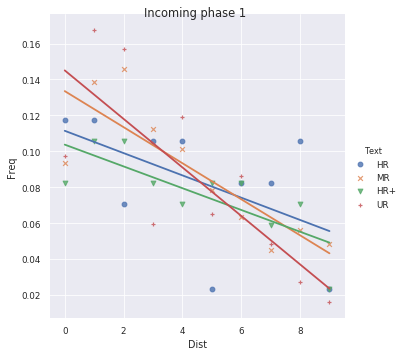

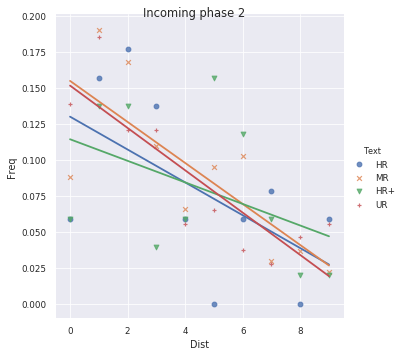

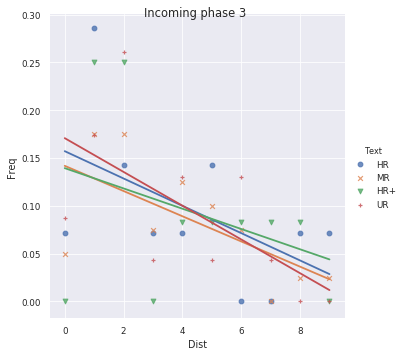

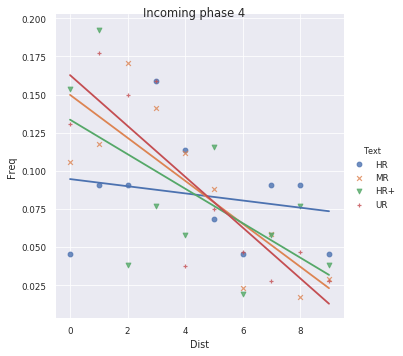

In [204]:
sns.lmplot(x="Dist", y="Freq", hue="Text", ci=None, markers=["o", "x", "v", "+"],
           data=pdist_fix_max_cos.loc[(pdist_fix_max_cos.ToPhase == 0) & (pdist_fix_max_cos.Dist < 10)]).fig.suptitle("Incoming phase 1");

if save_images:
    plt.savefig(image_path + os.sep + "pdist_freq_1.svg", format="svg")
    
sns.lmplot(x="Dist", y="Freq", hue="Text", ci=None, markers=["o", "x", "v", "+"],
           data=pdist_fix_max_cos.loc[(pdist_fix_max_cos.ToPhase == 1) & (pdist_fix_max_cos.Dist < 10)]).fig.suptitle("Incoming phase 2");

if save_images:
    plt.savefig(image_path + os.sep + "pdist_freq_2.svg", format="svg")

sns.lmplot(x="Dist", y="Freq", hue="Text", ci=None, markers=["o", "x", "v", "+"],
           data=pdist_fix_max_cos.loc[(pdist_fix_max_cos.ToPhase == 2) & (pdist_fix_max_cos.Dist < 10)]).fig.suptitle("Incoming phase 3");

if save_images:
    plt.savefig(image_path + os.sep + "pdist_freq_3.svg", format="svg")

sns.lmplot(x="Dist", y="Freq", hue="Text", ci=None, markers=["o", "x", "v", "+"],
           data=pdist_fix_max_cos.loc[(pdist_fix_max_cos.ToPhase == 3) & (pdist_fix_max_cos.Dist < 10)]).fig.suptitle("Incoming phase 4");

if save_images:
    plt.savefig(image_path + os.sep + "pdist_freq_4.svg", format="svg")


Lower effects except for phase 2

Now using a large number of permutations

In [205]:
random.seed(0)
nb_perm = 1000
list_ptf_files = [] # List of files to be transmitted to R

for p in range(nb_perm):
    perm_rdf = phase_permutation_constr(rdf)
    prdfD, ptransition_target_distance_D, pfreq_transition_target_distance_D, \
        pTD_df, pst_df, pdist_fix_max_cos = transition_target(perm_rdf, max_fst, nb_text_type_2)
    PTD_file = os.path.join(tempdir, 'ptd_file_'+str(p)+'.csv')
    pTD_df.to_csv(PTD_file)
    list_ptf_files += [PTD_file]
    if p % 200 == 0:
        print("Processing file: " + PTD_file)

df_list_ptf_files = pd.DataFrame(list_ptf_files, columns=["filenames"])
list_ptf_file = os.path.join(tempdir, 'list_ptd_file.csv')
df_list_ptf_files.to_csv(list_ptf_file)

Processing file: /tmp/tmplhRfn7/ptd_file_0.csv
Processing file: /tmp/tmplhRfn7/ptd_file_200.csv
Processing file: /tmp/tmplhRfn7/ptd_file_400.csv
Processing file: /tmp/tmplhRfn7/ptd_file_600.csv
Processing file: /tmp/tmplhRfn7/ptd_file_800.csv


Reestimation of linear mixed models on frequencies

In [206]:
%%R -i list_ptf_file -o BIC_diff_list

file_names = read.csv(list_ptf_file, row.names=1)
nb_perm = dim(file_names)[1]

BIC_diff_list = c()

for (i in 1:nb_perm) {
    PTC_file = as.character(file_names$filenames[i])
    PTC = dist.table(PTC_file, 2) 
    PTC$freq = PTC$counts / PTC$total
    modtclin.all.ran = lmer(freq ~ dist * TEXT_TYPE_2 * PHASE + (1|SUBJ), data=PTC)
    modtclin.all.ran.biclm = BICLM(modtclin.all.ran)
    modtclin.null.ran = lmer(freq ~ PHASE * TEXT_TYPE_2 + (1|SUBJ), data=PTC)
    modtclin.null.ran.biclm = BICLM(modtclin.null.ran)
    BIC_diff_list[i] = modtclin.all.ran.biclm - modtclin.null.ran.biclm
}


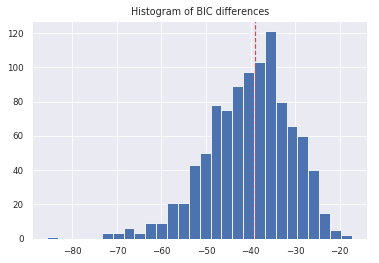

In [207]:
plt.hist(BIC_diff_list, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram of BIC differences")
Text(0.5, 1.0, "Histogram of BIC differences")
plt.axvline(x=BICLM_null_diff, color='r', linestyle='--')

if save_images:
    plt.savefig(image_path + os.sep + "BIC_diff_perm_constr.svg", format="svg")
    
plt.show()

Proportion of random samples where BIC diff is as large as true diff

In [208]:
np.less(BIC_diff_list,BICLM_null_diff).sum()/float(len(BIC_diff_list))

0.51900000000000002

51.9% samples have BIC difference lower than -39 (more significant than true data)

Same with GLMMs on transitions (binary)

In [209]:
%%R -i list_ptf_file -o BIC_diff_list

file_names = read.csv(list_ptf_file, row.names=1)
nb_perm = dim(file_names)[1]

BIC_diff_list = c()

for (i in 1:nb_perm) {
    PTC_file = as.character(file_names$filenames[i])
    PTC = dist.table(PTC_file, 2) 
    modtc.nop.ran = glmer(y ~ dist * TEXT_TYPE_2  + PHASE + (1|SUBJ), family="binomial", data=PTC)
    modtc.nop.ran.biclm = BICLM(modtc.nop.ran)
    modtc.null.ran = glmer(y ~ PHASE + TEXT_TYPE_2 + (1|SUBJ), family="binomial", data=PTC)
    modtc.null.ran.biclm = BICLM(modtc.null.ran)
    BIC_diff_list[i] = modtc.nop.ran.biclm - modtc.null.ran.biclm
}


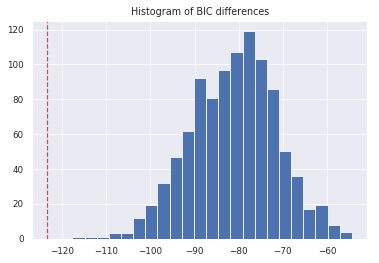

In [210]:
plt.hist(BIC_diff_list, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram of BIC differences")
Text(0.5, 1.0, "Histogram of BIC differences")
plt.axvline(x=BICLM_null_diff_bin, color='r', linestyle='--')

if save_images:
    plt.savefig(image_path + os.sep + "BIC_diff_perm_constr_bin.svg", format="svg")
    
plt.show()

Proportion of random samples where BIC diff is as large as true diff

In [211]:
np.less(BIC_diff_list,BICLM_null_diff_bin).sum()/float(len(BIC_diff_list))

0.0

0% samples have BIC difference lower than -123 (more significant than true data)

__Now constraining transitions to preserve empirical numbers of transitions and phase frequencies__

Compute phase frequencies in true data set

In [212]:
phase_freq = rdf[['PHASE']].apply(pd.value_counts) / rdf.shape[0]
phase_freq = phase_freq.sort_index()
phase_freq = list(phase_freq.PHASE)

Resample transition locations and permute phase positions (with free<br> 
numbers of transitions and phase values)

In [213]:
try:
    from pyene_analysis.ema_utils import phase_permutation_rand
except ImportError:
    import numpy as np
    import pandas as pd

    def phase_permutation_rand(rdf, phase_freq):
        """
        Resample transition locations and permute phase positions 
        (sample from empirical number of transitions 
        and empirical phase frequencies)
        """
        nb_phases = len(phase_freq)

        perm_rdf = rdf.copy()

        # Find restored scanpaths

        rs = {} # restored scanpaths
        ends = perm_rdf.loc[rdf['ISLAST'] == 1].index.tolist()
        nb_trans = [] # Number of transitions

        b = 0 # beginning
        i = 0 # index
        for e in ends:
            rs[i] = list(perm_rdf.PHASE[b:(e+1)])
            nb_trans += [len([j for j in range(len(rs[i])) if \
                (j < len(rs[i])-1) and (rs[i][j] != rs[i][j+1])])]
            b = e+1
            i += 1

        b = 0 # beginning
        for s in sorted(rs.keys()):
            e = ends[s] # End of scanpath
            scanp = rs[s]
            # New number of transitions
            nt = min(np.random.choice(nb_trans, size=1)[0], len(scanp)-1)
            # New phases
            val_phase = np.random.choice(range(nb_phases), size=nt+1, replace=True, p=phase_freq)
            if nt > 0:
                # New locations
                trans_loc = np.sort(np.random.choice(range(len(scanp)-1), size=nt, replace=False))
                # Check that incoming and outgoing phases are distinct
                phase_ctrl = [j for j in range(len(val_phase)) if (j < len(val_phase)-1) and \
                            (val_phase[j] != val_phase[j+1])]
                while (len(phase_ctrl) != len(val_phase)-1):
                    val_phase = np.random.choice(range(nb_phases), size=nt+1, replace=True, p=phase_freq)
                    phase_ctrl = [j for j in range(len(val_phase)) if (j < len(val_phase)-1) and \
                                (val_phase[j] != val_phase[j+1])]
                p = 0
                scanp = (trans_loc[p]+1) * [val_phase[p]]
                # Add all phases except last transition    
                for p in range(1, len(trans_loc)):
                    scanp += (trans_loc[p]-trans_loc[p-1]) * [val_phase[p]]
                # Add last transition
                p += 1
                scanp += (len(rs[s])-len(scanp)) * [val_phase[p]]
            else:
                scanp = len(scanp) * [val_phase[0]]
            perm_rdf.loc[b:e,'PHASE'] = scanp
            b = e+1

        return(perm_rdf, nb_trans)


Illustrate the effect of phase permutations on just one example

In [214]:
random.seed(100)
perm_rdf, nb_trans = phase_permutation_rand(rdf, phase_freq)
prdfD, ptransition_target_distance_D, pfreq_transition_target_distance_D, \
    pTD_df, pst_df, pdist_fix_max_cos = transition_target(perm_rdf, max_fst, nb_text_type_2)


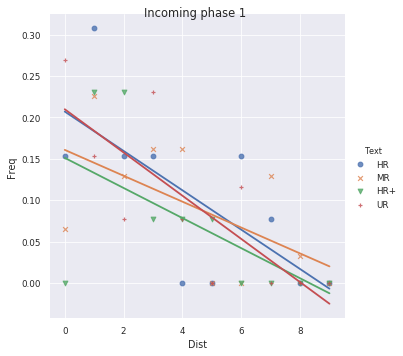

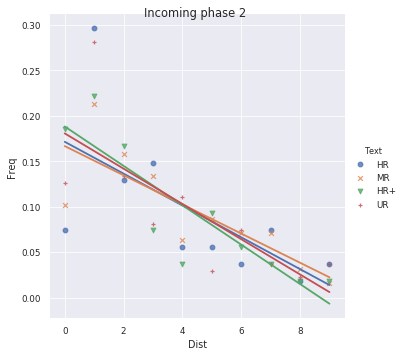

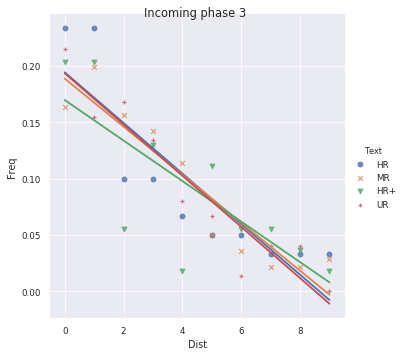

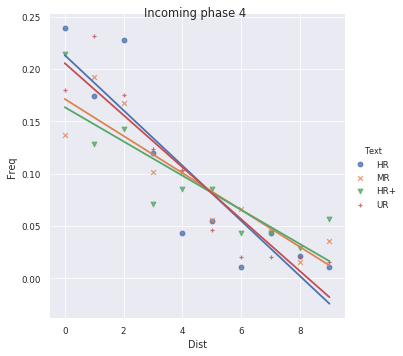

In [215]:
sns.lmplot(x="Dist", y="Freq", hue="Text", ci=None, markers=["o", "x", "v", "+"],
           data=pdist_fix_max_cos.loc[(pdist_fix_max_cos.ToPhase == 0) & (pdist_fix_max_cos.Dist < 10)]).fig.suptitle("Incoming phase 1");

if save_images:
    plt.savefig(image_path + os.sep + "pfdist_freq_1.svg", format="svg")
    
sns.lmplot(x="Dist", y="Freq", hue="Text", ci=None, markers=["o", "x", "v", "+"],
           data=pdist_fix_max_cos.loc[(pdist_fix_max_cos.ToPhase == 1) & (pdist_fix_max_cos.Dist < 10)]).fig.suptitle("Incoming phase 2");

if save_images:
    plt.savefig(image_path + os.sep + "pfdist_freq_2.svg", format="svg")

sns.lmplot(x="Dist", y="Freq", hue="Text", ci=None, markers=["o", "x", "v", "+"],
           data=pdist_fix_max_cos.loc[(pdist_fix_max_cos.ToPhase == 2) & (pdist_fix_max_cos.Dist < 10)]).fig.suptitle("Incoming phase 3");

if save_images:
    plt.savefig(image_path + os.sep + "pfdist_freq_3.svg", format="svg")

sns.lmplot(x="Dist", y="Freq", hue="Text", ci=None, markers=["o", "x", "v", "+"],
           data=pdist_fix_max_cos.loc[(pdist_fix_max_cos.ToPhase == 3) & (pdist_fix_max_cos.Dist < 10)]).fig.suptitle("Incoming phase 4");

if save_images:
    plt.savefig(image_path + os.sep + "pfdist_freq_4.svg", format="svg")


In [216]:
random.seed(0)
list_ptf_files_r = [] # List of files to be transmitted to R

for p in range(nb_perm):
    perm_rdf, nb_trans = phase_permutation_rand(rdf, phase_freq)
    prdfD, ptransition_target_distance_D, pfreq_transition_target_distance_D, \
        pTD_df, pst_df, pdist_fix_max_cos = transition_target(perm_rdf, max_fst, nb_text_type_2)
    PTD_file = os.path.join(tempdir, 'ptd_file_'+str(p)+'.csv')
    pTD_df.to_csv(PTD_file)
    list_ptf_files_r += [PTD_file]
    if p % 200 == 0:
        print("Processing file: " + PTD_file)

df_list_ptf_files = pd.DataFrame(list_ptf_files_r, columns=["filenames"])
list_ptf_files_r = os.path.join(tempdir, 'list_ptd_file_r.csv')
df_list_ptf_files.to_csv(list_ptf_files_r)

Processing file: /tmp/tmplhRfn7/ptd_file_0.csv
Processing file: /tmp/tmplhRfn7/ptd_file_200.csv
Processing file: /tmp/tmplhRfn7/ptd_file_400.csv
Processing file: /tmp/tmplhRfn7/ptd_file_600.csv
Processing file: /tmp/tmplhRfn7/ptd_file_800.csv


In [217]:
%%R -i list_ptf_files_r -o BIC_diff_list_r

file_names = read.csv(list_ptf_files_r, row.names=1)
nb_perm = dim(file_names)[1]

BIC_diff_list_r = c()

for (i in 1:nb_perm) {
    PTC_file = as.character(file_names$filenames[i])
    PTC = dist.table(PTC_file, 2) 
    PTC$freq = PTC$counts / PTC$total
    modtclin.all.ran = lmer(freq ~ dist * TEXT_TYPE_2 * PHASE + (1|SUBJ), data=PTC)
    modtclin.all.ran.biclm = BICLM(modtclin.all.ran)
    modtclin.null.ran = lmer(freq ~ PHASE * TEXT_TYPE_2 + (1|SUBJ), data=PTC)
    modtclin.null.ran.biclm = BICLM(modtclin.null.ran)
    BIC_diff_list_r[i] = modtclin.all.ran.biclm - modtclin.null.ran.biclm
}


/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: boundary (singular) fit: see ?isSingular

  warnings.warn(x, RRuntimeWarning)


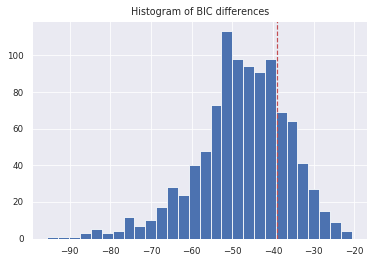

In [218]:
plt.hist(BIC_diff_list_r, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram of BIC differences")
Text(0.5, 1.0, "Histogram of BIC differences")
plt.axvline(x=BICLM_null_diff, color='r', linestyle='--')

if save_images:
    plt.savefig(image_path + os.sep + "BIC_diff_perm_constr_bin_r.svg", format="svg")
    
plt.show()

Proportion of random samples where BIC diff is as large as true diff

In [219]:
np.less(BIC_diff_list_r,BICLM_null_diff).sum()/float(len(BIC_diff_list))

0.78300000000000003

78.3% samples have BIC difference lower than -39 (more significant than true data)  

__Same with GLMMs__

In [220]:
%%R -i list_ptf_files_r -o BIC_diff_list_r

file_names = read.csv(list_ptf_files_r, row.names=1)
nb_perm = dim(file_names)[1]

BIC_diff_list_r = c()

for (i in 1:nb_perm) {
    PTC_file = as.character(file_names$filenames[i])
    PTC = dist.table(PTC_file, 2) 
    PTC$freq = PTC$counts / PTC$total
    modtc.nop.ran = glmer(y ~ dist * TEXT_TYPE_2  + PHASE + (1|SUBJ), family="binomial", data=PTC)
    modtc.nop.ran.biclm = BICLM(modtc.nop.ran)
    modtc.null.ran = glmer(y ~ PHASE + TEXT_TYPE_2 + (1|SUBJ), family="binomial", data=PTC)
    modtc.null.ran.biclm = BICLM(modtc.null.ran)
    BIC_diff_list_r[i] = modtc.nop.ran.biclm - modtc.null.ran.biclm
}


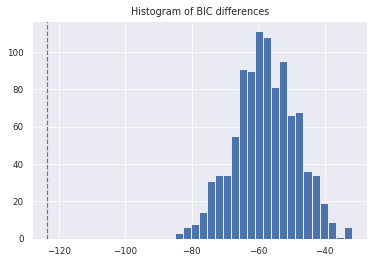

In [221]:
plt.hist(BIC_diff_list_r, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram of BIC differences")
Text(0.5, 1.0, "Histogram of BIC differences")
plt.axvline(x=BICLM_null_diff_bin, color='r', linestyle='--')

if save_images:
    plt.savefig(image_path + os.sep + "BIC_diff_perm_constr_r.svg", format="svg")
    
plt.show()

Proportion of random samples where BIC diff is as large as true diff

In [222]:
np.less(BIC_diff_list_r,BICLM_null_diff_bin).sum()/float(len(BIC_diff_list))

0.0

0% samples have BIC difference lower than -123 (more significant than true data)  

__Correspondence analysis: relations between phases and subjects__

In [223]:
# subj_phase_table = rdf.groupby(['SUBJ_NAME', 'PHASE'])['SUBJ_NAME', 'PHASE'].count()
subj_phase_table = rdf[['SUBJ_NAME', 'PHASE']]

In [224]:
CNT_file = os.path.join(tempdir, 'cnt_file.csv')
subj_phase_table.to_csv(CNT_file)

In [225]:
CA_file = os.path.join(R_PATH, "ca.R")

[1]  1.00  0.36 68.23 68.23
[1]  2.00  0.16 30.45 98.68
[1]   3.000   0.007   1.323 100.000
Quality of representation for individual  s01  on  4  axes : 
[1] 96.180188  2.307600  1.512211
Quality of representation for individual  s02  on  4  axes : 
[1] 94.562050  4.364658  1.073292
Quality of representation for individual  s04  on  4  axes : 
[1] 19.420898 79.955735  0.623367
Quality of representation for individual  s05  on  4  axes : 
[1] 98.5878148  1.2123455  0.1998396
Quality of representation for individual  s06  on  4  axes : 
[1] 95.6967260  3.3782262  0.9250478
Quality of representation for individual  s07  on  4  axes : 
[1] 63.2731523 36.4491614  0.2776863
Quality of representation for individual  s08  on  4  axes : 
[1] 5.819868e+01 4.180123e+01 8.891101e-05
Quality of representation for individual  s10  on  4  axes : 
[1] 99.1570643  0.3208509  0.5220848
Quality of representation for individual  s13  on  4  axes : 
[1] 96.014751  3.470005  0.515244
Quality of representati

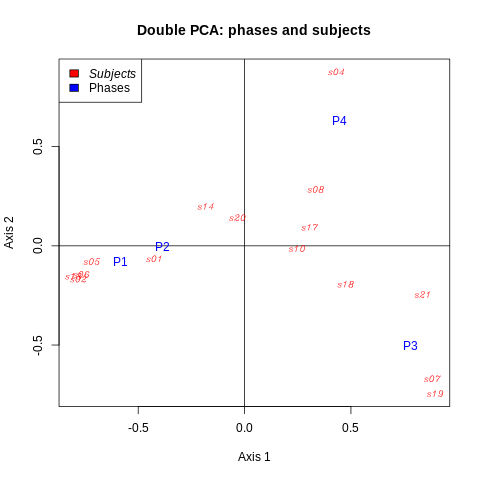

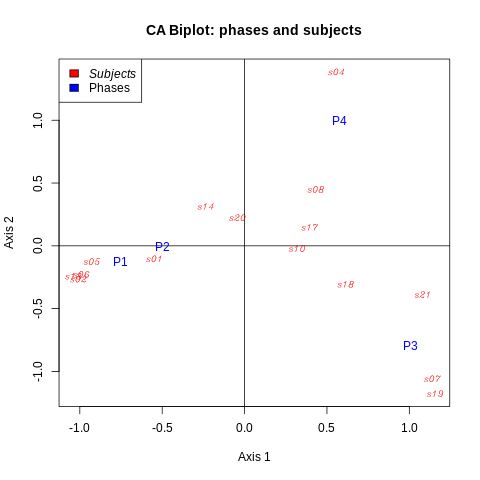

In [226]:
%%R -i CNT_file -i R_PATH -i CA_file -i output_path

df_CNT = read.table(CNT_file, sep=",", header=TRUE, row.names=1)

# Contingency table: 
T_CNT = as.data.frame.matrix(table(df_CNT[,1], df_CNT[,2]))

for (i in 1:dim(T_CNT)[2]) 
    names(T_CNT)[i] = paste("P", names(T_CNT)[i], sep="")

source(CA_file)

ca = corresp(T_CNT, "phases and subjects", "topleft", "Subjects", "Phases", image_path)

print(paste("P-value of independence test:", ca$chisq$p.value))
print(paste("Statistic of independence test:", ca$chisq$statistic))
print(paste("D.o.f. of independence test:", ca$chisq$parameter))


In [227]:
os.remove(CNT_file)

__Remove temporary folder__

In [228]:
import shutil
shutil.rmtree(tempdir)

In [229]:
import dill
# dill.dump_session('notebook_env.db')